In [1]:
#C'est ici que toute la documentation du pipeline, les résultats et les analyses visuelles sont intégrés.
#Ce notebook contient les explications et appelle les scripts du dossier src/ pour exécuter chaque étape du pipeline.
#On l'utilise pour charger et exécuter le pipeline étape par étape. 
#Par exemple, pour exécuter la partie nettoyage, importer et exécuter data_preprocessing.py depuis src/.
#À chaque étape (nettoyage, analyse des données, visualisations), ajouter des cellules Markdown dans le notebook pour expliquer ce que fait chaque étape, pourquoi elle est nécessaire, et les observations tirées des résultats.
#C’est également ici que nous ajouterons les graphiques et analyses visuelles pour expliquer nos résultats intermédiaires.

In [2]:
#Expliquer ce que l'on fait dans notre projet et que pour ce faire nous utiliserons une version clean de movie_metadata.
#On affiche à partir de quelle année notre base de données de films commence pour exclure les évènements historiques trop lointains dans notre dataset additionnel.
#On veut garder la première colonne pour relier le film à son résumé mais aussi la plupart des autres.
#On veut transformer les formats de dates pour l’analyse temporelle.

# ADA Project - Milestone 2

First and foremost, we must setup the environment with the installation of appropriate libraries. 

In [1]:
from tests.test_data_preprocessing import test_cleaned_movie_data
import matplotlib.pyplot as plt 
import pandas as pd
import ast
import numpy as np
import seaborn as sns
from appendix import extract_names, extract_year, outliers_bounds
from appendix import *
from sklearn.preprocessing import MultiLabelBinarizer 
import geopandas as gpd

Before beginning our study, we must proceed with data wrangling, transforming raw data into a structured and usable format for analysis.
This includes associating the correct names to our columns, removing outliers, nan and abherrent values and structuring our data so that it may be easier to work with. 

## 1 - Data Collection

We begin with an initial overview of the raw imported data

In [2]:
raw_movies_data = pd.read_csv("data/MovieSummaries/movie.metadata.tsv", header= None, delimiter='\t') # Columns are separated by tabs rather than commas
print("The initial dataframe has ", len(raw_movies_data), "lines.")

The initial dataframe has  81741 lines.


In [3]:
raw_movies_data.head(3)

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


## 2 - Data Cleaning 

At the first steps of our analysis, we must name the columns for clarity, standardize the data and remove abherrent as well as nan values.

In [4]:
headers = ["Wikipedia movie ID",
    "Freebase movie ID",
    "Movie name",
    "Movie release date",
    "Movie box office revenue",
    "Movie runtime",
    "Movie languages (Freebase ID:name tuples)",
    "Movie countries (Freebase ID:name tuples)",
    "Movie genres (Freebase ID:name tuples)"]
raw_movies_data.columns = headers

The data in the columns for language, countries and genres is in a complex format that includes the Freebase ID. We need to extract and transform this data into a simpler format, making it ready for further analysis.

In [5]:
#remove the id, only keep the name
raw_movies_data["Languages"] = raw_movies_data["Movie languages (Freebase ID:name tuples)"].apply(extract_names)
raw_movies_data["Countries"] = raw_movies_data["Movie countries (Freebase ID:name tuples)"].apply(extract_names)
raw_movies_data["Genres"] = raw_movies_data["Movie genres (Freebase ID:name tuples)"].apply(extract_names)
raw_movies_data.drop(columns=["Movie languages (Freebase ID:name tuples)", "Movie countries (Freebase ID:name tuples)", "Movie genres (Freebase ID:name tuples)"], inplace=True)
raw_movies_data.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Norwegian Language,Norway,"Crime Fiction, Drama"


### Handling missing values

We can use a heatmap to visualize the missing values from our raw data. Each white line corresponds to a missing value. 

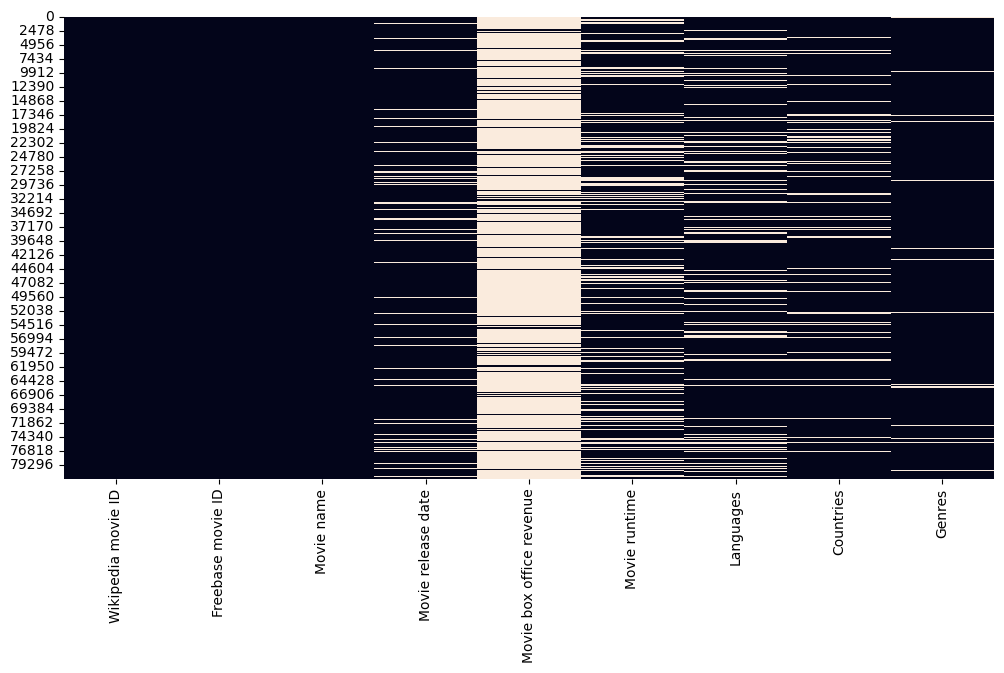

In [6]:
#Replace " " by NaN
clean_movies_data=raw_movies_data.copy()
clean_movies_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#Plot for the missing values
plt.figure(figsize=(12, 6))
sns.heatmap(clean_movies_data.isnull(), cbar=False)
plt.show()

The columns 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Languages', 'Countries' and 'Genres' contain a number of missing values. Let's quantify them :

In [7]:
#compute the percentage of missing values for each column
nb_missing_values = clean_movies_data.isnull().sum().sort_values(ascending=False)
missing_values_percentage = (clean_movies_data.copy().isnull().mean() * 100).sort_values(ascending=False)
#display in a dataframe
missing_values_df = pd.DataFrame({
    'Missing values': nb_missing_values,
    'Percentage (%)': missing_values_percentage
})
print(missing_values_df)

                          Missing values  Percentage (%)
Movie box office revenue           73340       89.722416
Movie runtime                      20450       25.018045
Languages                          13866       16.963335
Countries                           8154        9.975410
Movie release date                  6902        8.443743
Genres                              2294        2.806425
Wikipedia movie ID                     0        0.000000
Freebase movie ID                      0        0.000000
Movie name                             0        0.000000


Almost 90% of the movies are missing the information about the box office revenue, thus we cannot drop the rows with missing value in this column. However, our analysis focuses on movie genres so we need to drop the rows where the data for the movie genre is missing. By doing so, we loose around 2.8% of the data (2294 rows), which is reasonnable.

In [8]:
#The lines with nan values in genre are removed
clean_movies_data= clean_movies_data.dropna(subset=["Genres"])
len(clean_movies_data)

79447

Another fundamental variable for our project is the movie release date. Movies with missing dates are unusable and must therefore be removed from the dataset. This corresponds to another 6370 movies.

In [9]:
clean_movies_data = clean_movies_data.dropna(subset=["Movie release date"])
print(len(clean_movies_data))
percent_removed=(len(raw_movies_data)-len(clean_movies_data))/len(raw_movies_data)*100
print(f"{percent_removed:.2f}")

73077
10.60


After handling the missing values, we are left with 73077 movies in our data set. We removed 10.6% of the rows. This ensures that our analysis will stay pertinent

### Data standardization

We also observe that the movie release dates are in different formats, so we need to standardize the data. For our analysis, we will only need the year.

In [10]:
clean_movies_data['Year'] = clean_movies_data['Movie release date'].apply(extract_year)
clean_movies_data.drop(columns=["Movie release date"], inplace=True)
clean_movies_data.head(3)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,Norwegian Language,Norway,"Crime Fiction, Drama",1988


In [11]:
print(len(clean_movies_data))
clean_movies_data= clean_movies_data.dropna(subset=["Year"])
print(len(clean_movies_data))

73077
73076


The function extract_year failed to transform one date. The corresponding row is removed from the dataset

### Handling outliers

Now that we've looked at missing values, it is time to assess for outliers and abherrent values from our data. 

#### > Year

Already done in analysis part

#### > Movie runtime

In [12]:
clean_movies_data['Movie runtime'].describe()

count    5.820500e+04
mean     1.124085e+02
std      4.473661e+03
min      0.000000e+00
25%      8.100000e+01
50%      9.300000e+01
75%      1.060000e+02
max      1.079281e+06
Name: Movie runtime, dtype: float64

From the boxplot and statistical description of this variable, we are able to identify outliers. The maximum value (1 million) is clearly aberrant. The other outliers can be defined using a certain threshold range and removed from the dataset, but it is not needed for our project. 

There are 4013 outliers among the 58205 runtime values, which corresponds to 6.89% of the values.


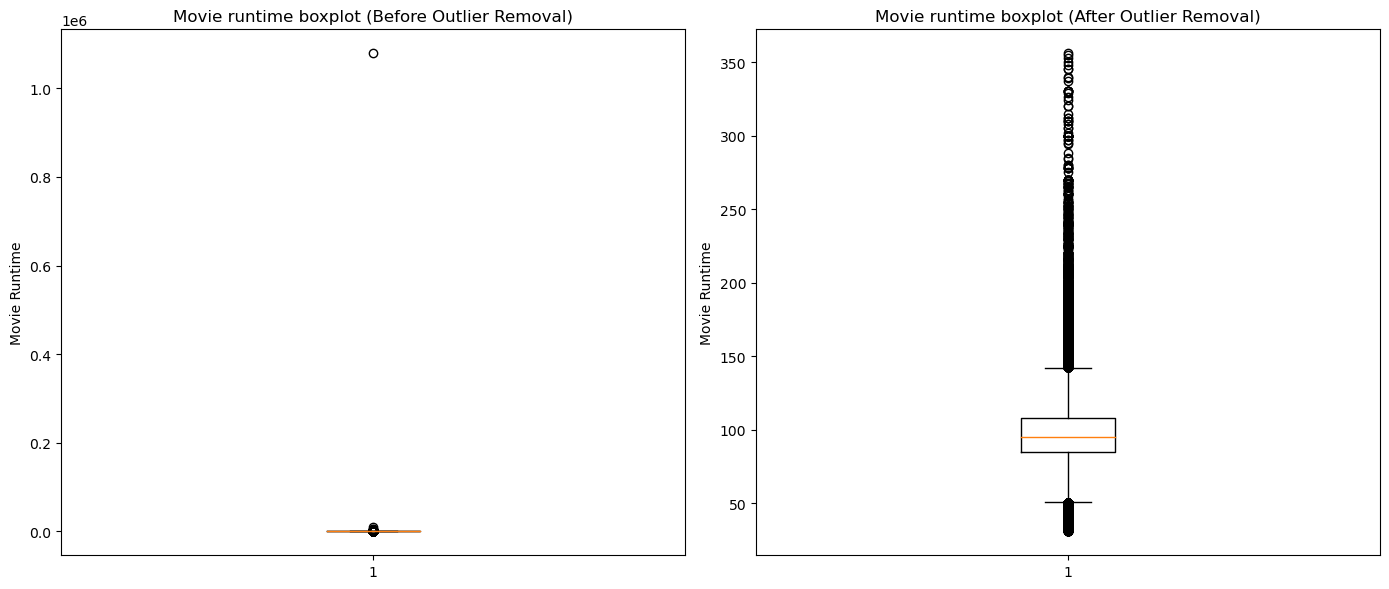

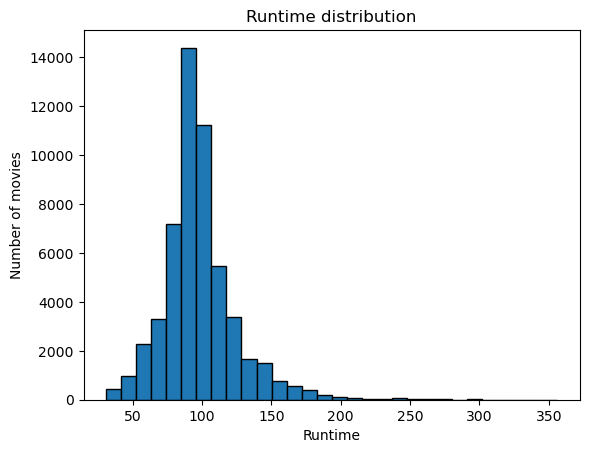

count    54192.000000
mean        98.379926
std         27.176730
min         31.000000
25%         85.000000
50%         95.000000
75%        108.000000
max        356.000000
Name: Movie runtime, dtype: float64

In [13]:
#Analysis of the column 'Runtime'
runtime_data=clean_movies_data['Movie runtime'].dropna()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
# Boxplot before outlier removal
ax[0].boxplot(runtime_data)
ax[0].set_title('Movie runtime boxplot (Before Outlier Removal)')
ax[0].set_ylabel('Movie Runtime')


#Identification of outliers
low_factor=2
up_factor = 10 #We choose a large factor because the distribution is right-skewed and we want to make sure that we do not exclude values that are not outliers
lower_bound, upper_bound=outliers_bounds(runtime_data, low_factor, up_factor)
outliers = runtime_data[(runtime_data < lower_bound) | (runtime_data > upper_bound)]
print(f"There are {len(outliers)} outliers among the {len(runtime_data)} runtime values, which corresponds to {len(outliers)/len(runtime_data)*100:.2f}% of the values.")

#Remove the outliers 
no_outlier_data=clean_movies_data.copy()
no_outlier_data = no_outlier_data[(no_outlier_data['Movie runtime'] >= lower_bound) & (no_outlier_data['Movie runtime'] <= upper_bound)]

#Boxplot after outlier removal
ax[1].boxplot(no_outlier_data['Movie runtime'])
ax[1].set_title('Movie runtime boxplot (After Outlier Removal)')
ax[1].set_ylabel('Movie Runtime')

#Adjust layout for better spacing
plt.tight_layout()

#Show the plots
plt.show()


#Runtime distribution
plt.figure()
plt.hist(no_outlier_data['Movie runtime'], bins=30, edgecolor='black')
plt.title('Runtime distribution')
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.show()

no_outlier_data['Movie runtime'].describe()

#### > Box Office

In [14]:
clean_movies_data['Movie box office revenue'].describe()

count    8.322000e+03
mean     4.829252e+07
std      1.124969e+08
min      1.000000e+04
25%      2.101250e+06
50%      1.082159e+07
75%      4.117065e+07
max      2.782275e+09
Name: Movie box office revenue, dtype: float64

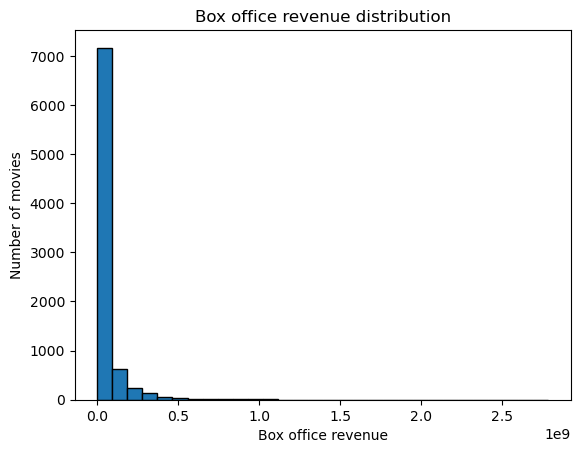

In [15]:
#Box office revenue distribution
plt.figure()
plt.hist(clean_movies_data['Movie box office revenue'], bins=30, edgecolor='black')
plt.title('Box office revenue distribution')
plt.xlabel('Box office revenue')
plt.ylabel('Number of movies')
plt.show()

In [16]:
top_10_box_office = clean_movies_data.sort_values(by='Movie box office revenue', ascending=False).head(10)
top_10_box_office

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
23702,4273140,/m/0bth54,Avatar,2.782275e+09,178.0,"English Language, Spanish Language","United States of America, United Kingdom","Thriller, Science Fiction, Adventure, Computer...",2009
22256,52371,/m/0dr_4,Titanic,2.185372e+09,194.0,"Italian Language, English Language, French Lan...",United States of America,"Tragedy, Costume drama, Historical fiction, Ac...",1997
28192,22114132,/m/062zm5h,The Avengers,1.511758e+09,137.0,"Russian Language, English Language",United States of America,"Science Fiction, Action",2012
30278,31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,1.328111e+09,130.0,English Language,"United States of America, United Kingdom","Drama, Mystery, Fantasy, Adventure",2011
18645,25001260,/m/0872p_c,Transformers: Dark of the Moon,1.123747e+09,157.0,English Language,United States of America,"Alien Film, Science Fiction, Action, Adventure",2011
80920,174251,/m/017jd9,The Lord of the Rings: The Return of the King,1.119930e+09,250.0,"Old English language, English Language","United States of America, New Zealand","Fantasy Adventure, Adventure, Epic, Action/Adv...",2003
54719,29075630,/m/0bpm4yw,The Dark Knight Rises,1.078009e+09,165.0,English Language,"United States of America, United Kingdom","Crime Fiction, Thriller, Action, Drama",2012
69586,1213838,/m/04hwbq,Toy Story 3,1.063172e+09,102.0,"English Language, Spanish Language",United States of America,"Adventure, Children's/Family, Computer Animati...",2010
14303,24314116,/m/09v8clw,Pirates of the Caribbean: On Stranger Tides,1.043872e+09,136.0,English Language,United States of America,"Swashbuckler films, Adventure, Costume Adventu...",2011
50039,50793,/m/0ddt_,Star Wars Episode I: The Phantom Menace,1.027045e+09,136.0,English Language,United States of America,"Science Fiction, Action, Fantasy, Adventure, F...",1999


There does not seem to be any significant outliers in this variable. This is reassuring because we are already quite limited in terms of number of instances as there are a great number of missing values for it.

### Removal of Unnecessary columns

We can drop the columns "Wikipedia movie ID" and "Freebase movie ID" because they won't be useful for our project. 

In [17]:
#remove unnecessary columns
clean_movies_data=clean_movies_data.drop(columns=["Wikipedia movie ID","Freebase movie ID"])
clean_movies_data.head()

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
0,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001
1,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000
2,Brun bitter,NaN,83.0,Norwegian Language,Norway,"Crime Fiction, Drama",1988
3,White Of The Eye,NaN,110.0,English Language,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987
4,A Woman in Flames,NaN,106.0,German Language,Germany,Drama,1983


### Save the cleaned dataset

In [18]:
processed_data_path = 'data/Preprocessed_data/preprocessed_movie_metadata.csv'

# Sauvegarder le DataFrame transformé
clean_movies_data.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)

In [19]:
preprocessed_movies = pd.read_csv("data/preprocessed_data/preprocessed_movie_metadata.csv")
print("The dataframe following preprocessing steps has ", len(preprocessed_movies), "lines.")
print(len(raw_movies_data) - len(preprocessed_movies), " lines were lost following the cleaning steps.")

The dataframe following preprocessing steps has  73076 lines.
8665  lines were lost following the cleaning steps.


In [20]:
preprocessed_movies.head()

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
0,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001
1,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000
2,Brun bitter,NaN,83.0,Norwegian Language,Norway,"Crime Fiction, Drama",1988
3,White Of The Eye,NaN,110.0,English Language,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987
4,A Woman in Flames,NaN,106.0,German Language,Germany,Drama,1983


## 3 - Preliminary Data Analysis

We wish to conduct an anaysis of the influence of historical and socio-cultural events on genre trends. Therefore we may begin observing the distribution of movie releases over time and the distribution of genres represented in our data.


## Number of movies over time

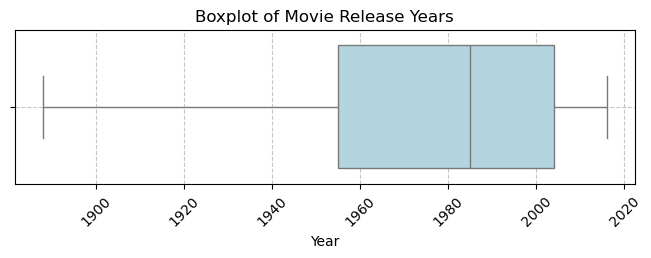

In [21]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=preprocessed_movies['Year'].astype(int), color='lightblue')
plt.title('Boxplot of Movie Release Years')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

It is important to note that for our future analysis that the number of films produced each year is not uniform. This variability should be considered when comparing film counts over time. In some cases, working with proportions rather than absolute numbers may provide us more interesting insights.


Text(0.5, 1.0, 'Number of movies per year')

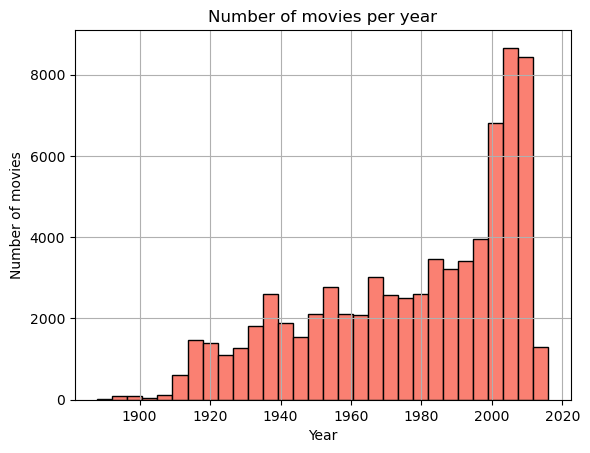

In [22]:
preprocessed_movies["Year"].hist(bins=30, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color = 'salmon', edgecolor = 'black')
plt.xlabel("Year")
plt.ylabel("Number of movies")
plt.title("Number of movies per year")

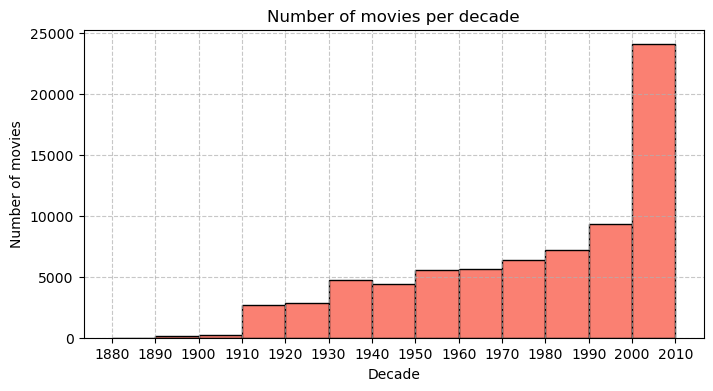

In [23]:
#Compute decade to which each movie corresponds
decades=(preprocessed_movies['Year'] // 10) * 10

plt.figure(figsize=(8, 4))
decades.hist(bins=range(decades.min(), decades.max() + 10, 10), color='salmon', edgecolor='black')
plt.xlabel("Decade")
plt.ylabel("Number of movies")
plt.xticks(range(decades.min(), decades.max() + 10, 10))
plt.title("Number of movies per decade")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Movies per countries

In our analysis, we aim to examine the impact of historical events on the film industry across different countries. To begin, let’s look at the number of movies produced by each country in our dataset.

Since movies can be associated with more than one country, we will split the dataset so that each country listed for a movie is counted individually. This way, a movie will be included once for each country it’s attributed to.

In [24]:
movies_per_country_counts = preprocessed_movies.assign(Countries=preprocessed_movies['Countries'].str.split(', ')).explode('Countries')
movies_per_country_counts = preprocessed_movies.assign(Countries=preprocessed_movies['Countries'].str.split(', ')).explode('Countries')
movies_per_country_counts = movies_per_country_counts['Countries'].value_counts().reset_index()
movies_per_country_counts.columns = ['Countries', 'Movie_Count']


# Load a geopandas dataframe with the world map
shapefile_path = 'data/geopandas/ne_110m_admin_0_countries.shp'
world_for_movie = gpd.read_file(shapefile_path)
world_for_movie = world_for_movie.rename(columns={'NAME': 'Countries'})

# Merged the geopandas dataframe with the movie count dataframe to display the number of movies per country on the world map                                        
merged = world_for_movie.merge(movies_per_country_counts, on='Countries', how='left')

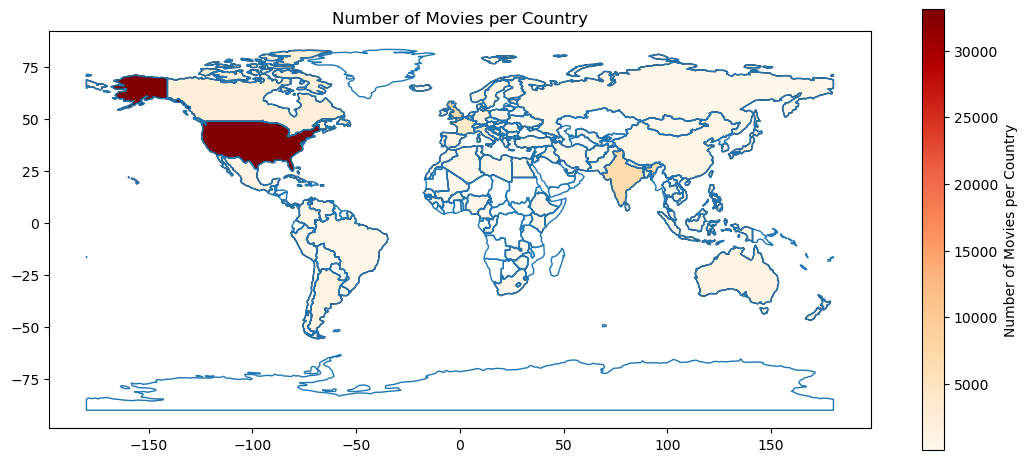

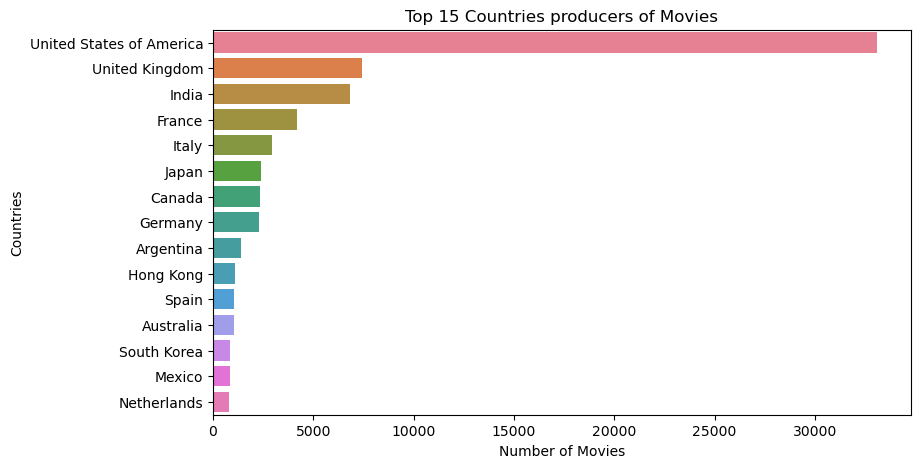

,Countries,Movie_Count
0,United States of America,33112
1,United Kingdom,7426


In [27]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))

fig.tight_layout()
world_for_movie.boundary.plot(ax=ax, linewidth=1)


legend_kwds={'label': "Number of Movies per Country",
             'orientation': "vertical"}

merged.plot(column='Movie_Count', ax=ax, legend=True,
            legend_kwds=legend_kwds,
            cmap='OrRd', edgecolor='black')

plt.title("Number of Movies per Country")
plt.show()

top15_contry_movie_production = movies_per_country_counts.iloc[:15]

plt.figure(figsize=(9, 5))
sns.barplot(x='Movie_Count', y='Countries', data=top15_contry_movie_production, hue='Countries', legend=False)
plt.ylabel('Countries')
plt.xlabel('Number of Movies')
plt.title('Top 15 Countries producers of Movies')
plt.show()

top15_contry_movie_production.head(2)

The United States has clearly dominated the film industry, with a total of 33,112 movies released—four times more than the United Kingdom, the second-highest producer of films. Let’s explore whether this dominance has been consistent over time or if it reflects a more recent trend.

#### PEUT ETRE A MITIGER CAR RIEN NOUS DIT QUE NOTRE DATASET EST REPRESENTATIF

,Top 1 country producer,Top 2 country producer,Top 3 country producer
Decade,,,
1850,France,United States of America,United Kingdom
1900,United States of America,United Kingdom,Germany
1950,United States of America,India,United Kingdom
2000,United States of America,India,United Kingdom


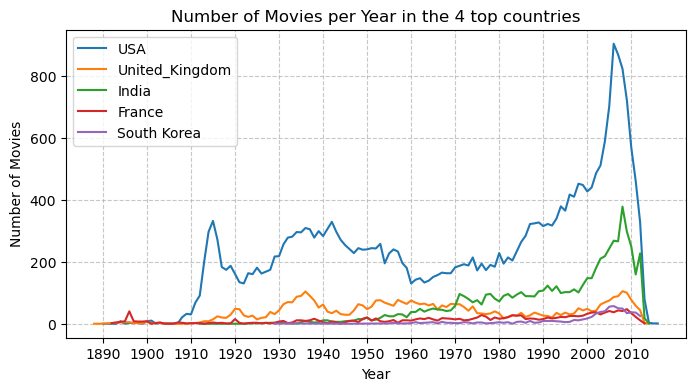

In [25]:
double_decades = (preprocessed_movies['Year'] // 50) * 50

best_country_per_decade = preprocessed_movies.assign(Countries=preprocessed_movies['Countries'].str.split(', ')).explode('Countries')

movies_per_decade_country = best_country_per_decade.groupby([double_decades, 'Countries']).size().unstack(fill_value=0)
top_3_countries_per_decade = movies_per_decade_country.apply(lambda x: x.nlargest(3).index.tolist(), axis=1)

# Create a DataFrame to display the top 10 countries per decade
top_3_countries_df = pd.DataFrame(top_3_countries_per_decade.tolist(), index=top_3_countries_per_decade.index)
top_3_countries_df.index.name = 'Decade'
top_3_countries_df.columns = [f'Top {i+1} country producer' for i in range(top_3_countries_df.shape[1])]

display(top_3_countries_df)

print("\n")

USA_movies = preprocessed_movies[preprocessed_movies['Countries']=='United States of America']
United_Kingdom_movies = preprocessed_movies[preprocessed_movies['Countries']=='United Kingdom']
France_movies = preprocessed_movies[preprocessed_movies['Countries']=='France']
India_movies = preprocessed_movies[preprocessed_movies['Countries']=='India'] 
South_Korea_movies = preprocessed_movies[preprocessed_movies['Countries']=='South Korea']

plt.figure(figsize=(8, 4))
plt.plot(USA_movies['Year'].value_counts().sort_index(), label='USA')
plt.plot(United_Kingdom_movies['Year'].value_counts().sort_index(), label='United_Kingdom')
plt.plot(India_movies['Year'].value_counts().sort_index(), label='India') 
plt.plot(France_movies['Year'].value_counts().sort_index(), label='France')
plt.plot(South_Korea_movies['Year'].value_counts().sort_index(), label='South Korea')

plt.title('Number of Movies per Year in the 4 top countries')
plt.xlabel('Year')
plt.xticks(range(preprocessed_movies['Year'].min()+2, preprocessed_movies['Year'].max(), 10))
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Number of Movies')
plt.legend()
plt.show()


We could see that the United States had always had an historical strong dominace on film industry since 1910. 

# Genre Movie exploring

In this section, we will examine how movies are classified into genres. Carefully analyzing, selecting and refining these genre classifications is essential for obtaining meaningful insights. 
We will discuss our approach to selecting and adjusting genres for our following study. 

In [26]:
#Number of genres in the dataset but we can see that there are a lot of categories that could be combined
genres = preprocessed_movies['Genres'].str.split(', ').explode().unique()

print(f"There are {len(genres)} genres in the dataset")
print("-"*32) 
print(f"\nList of all the genre: \n{genres}")
print("-"*32) 

There are 363 genres in the dataset
--------------------------------

List of all the genre: 
['Thriller' 'Science Fiction' 'Horror' 'Adventure' 'Supernatural' 'Action'
 'Space western' 'Mystery' 'Biographical film' 'Drama' 'Crime Drama'
 'Crime Fiction' 'Erotic thriller' 'Psychological thriller' 'Short Film'
 'Silent film' 'Indie' 'Black-and-white' 'Comedy' 'Family Film' 'Fantasy'
 'World cinema' 'Musical' 'Japanese Movies' 'Action/Adventure'
 'Romantic comedy' 'Ensemble Film' 'Comedy-drama' 'Romantic drama'
 'Romance Film' 'Costume drama' 'War film' 'Epic' 'Period piece'
 'Film adaptation' "Children's/Family" "Children's Fantasy" 'Future noir'
 'Comedy film' 'Coming of age' 'Suspense' 'Crime Thriller' 'Black comedy'
 'Bollywood' 'Marriage Drama' 'Wuxia' 'Martial Arts Film' 'Chinese Movies'
 'Western' 'Parody' 'Mockumentary' 'Fan film' 'Cult' 'Adventure Comedy'
 'Slapstick' 'Biopic [feature]' 'Historical Epic' 'Sports' 'Family Drama'
 'Political drama' 'Historical fiction' 'Courtroom 

Movies are classified into various genres that capture themes, styles, or settings. However, not all these aspects are relevant to our analysis, so we need to select genres that allow us to group films meaningfully.

Let's begin by  focusing on the number of movies in each genre category.

### Number of movie per genre

In [27]:
genres_counts = preprocessed_movies['Genres'].str.split(', ').explode().value_counts()

genres_counts

Genres
Drama                   32014
Comedy                  15648
Romance Film             9770
Black-and-white          8817
Thriller                 8407
                        ...  
Comdedy                     1
C-Movie                     1
Linguistics                 1
Silhouette animation        1
Homoeroticism               1
Name: count, Length: 363, dtype: int64

In [28]:
#Genres assigned to 10 movies or less
rare_genres = genres_counts[genres_counts <= 10]
rare_genres_counts = len(rare_genres)

print(f"Number of genres assigned to 10 movies or less  : {rare_genres_counts}")

Number of genres assigned to 10 movies or less  : 87


A lot of genres might not be meaningful because they contain few movies. In particular, 87 genres are assigned to 10 movies or less.

In order to keep only relevant genres, we can define an arbitrary threshold for the number of movies assigned to each genre.

In [29]:
#Threshold
threshold = 50
# Garder uniquement les genres assignés à plus de 50 films
relevant_genres = genres_counts[genres_counts > threshold]
print(f"Number of genres assigned to more than  movies {threshold}: {len(relevant_genres)}")

Number of genres assigned to more than  movies 50: 197


Now we look at the distribution of the most widespread genres.

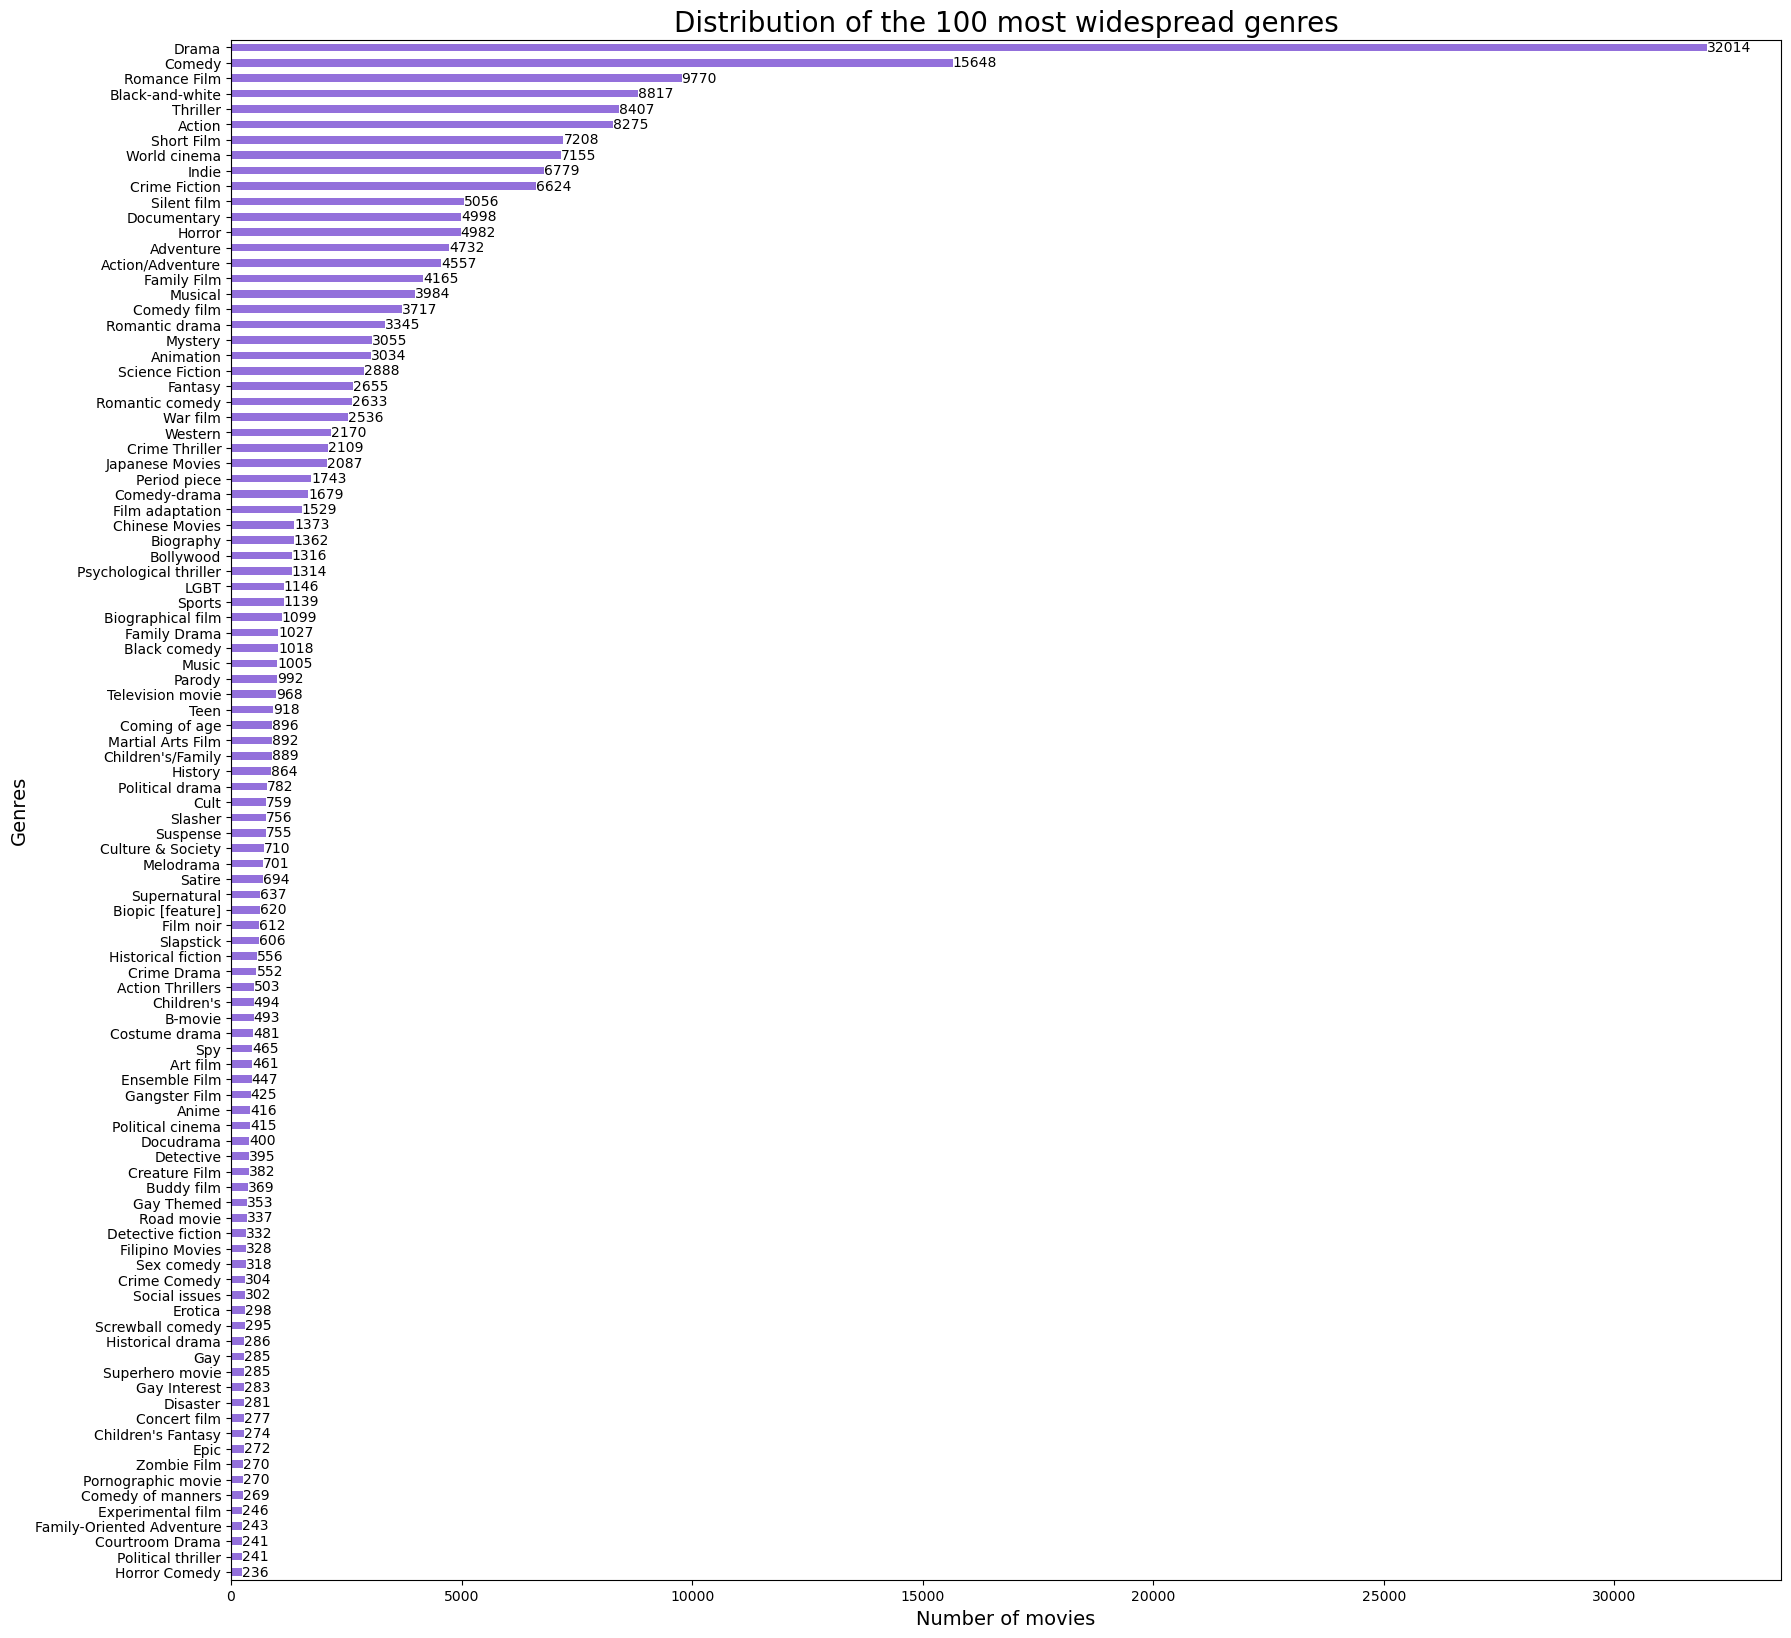

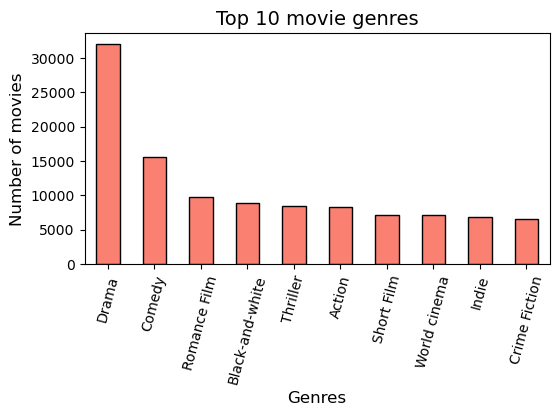

In [30]:
#We choose the 100 most widespread genres
top_100_genres = relevant_genres.head(100)

#Genres distribution
plt.figure(figsize=(20, 20))
top_100_genres.plot(kind='barh', color='#9370DB')
plt.xlabel('Number of movies', fontsize=14)
plt.ylabel('Genres', fontsize=14)
plt.title('Distribution of the 100 most widespread genres', fontsize=20)
plt.gca().invert_yaxis() 

#Display the number of movies for each genre category
for index, value in enumerate(top_100_genres):
    plt.text(value, index, str(value), va='center')
    
plt.show()


#A closer look : top 10 movie genres
top_10_genres = relevant_genres.iloc[:10]


top_10_genres.plot(kind='bar', x='Genres', y='Count', color='salmon', edgecolor='black', figsize=(6, 3))
plt.xlabel('Genres', fontsize=12)
plt.xticks(rotation=75)
plt.ylabel('Number of movies', fontsize=12)
plt.title('Top 10 movie genres', fontsize=14)
plt.show()

We observe that the 4th genre is "Black and White" and the 7th is "Short Film"—both of which are not relevant to our analysis. We can manually remove these and other unhelpful categories to focus on more meaningful genre information.

In [31]:
#remove all the genre that give information about the technical aspect of the movie rather than the content
technical_information = ['Silent film','Short Film','Musical', 'Film adaptation',"Black-and-white", "Music", "Teen", "Stop Motion"]
country_information = ["Indie","Japanese Movies", "Chinese Movies", "Bollywood"]
unwanted_genres = technical_information + country_information

preprocessed_movies['Genres'] = preprocessed_movies['Genres'].apply(lambda x: filter_genres(x, unwanted_genres=unwanted_genres))

### Balancing Genre Reduction with Dataset Coverage

Even if we want to choose a reduced set of genres, we still want to retain a significant portion of the dataset.\
We will try to identify the minimum number of genres needed to cover the majority of films in our dataset. \
Specifically, we want to analyze how many films fall into groups defined by an increasing number of genres and determine how many genres are required to capture, for example, 90% of all films. 

In [32]:
genre_movies = preprocessed_movies['Genres'].str.split(', ').explode()
genre_counts = genre_movies.value_counts().reset_index()
genre_counts.columns = ['Genres', 'Count']
genre_counts.head(10)

,Genres,Count
0,Drama,32014
1,Comedy,15648
2,Romance Film,9770
3,Thriller,8407
4,Action,8275
5,World cinema,7155
6,Crime Fiction,6624
7,Documentary,4998
8,Horror,4982
9,Adventure,4732


In [33]:
genre_counts_top_100 = genre_counts.iloc[:100]
genre_counts_top_30 = genre_counts.iloc[:30]
genre_counts_top_10 = genre_counts.iloc[:10]
genre_counts_top_3 = genre_counts.iloc[:3]

In [34]:
def most_common_genres(movies, genre_counts, top_n):
    movies_common_genre = movies.copy()

    #keep only the n top genres and replace the empty line by nan values
    movies_common_genre['Genres'] = movies_common_genre['Genres'].apply(lambda x: keep_only_the_most_common_genres(x, genre_counts=genre_counts))
    movies_common_genre['Genres'] = movies_common_genre['Genres'].apply(lambda x: np.nan if x == '' else x)
    
    #compute the portion of film qualified by the top n genre
    total = len(movies)
    covered = total - movies_common_genre['Genres'].isna().sum()
    coverage = (covered / total) * 100
    
    return movies_common_genre, coverage

# Define a list of genre counts for each top N genres
genre_counts_list = [genre_counts_top_100, genre_counts_top_30, genre_counts_top_10, genre_counts_top_3]
top_n_values = [100, 30, 10, 3]


coverages = {}
for top_n, genre_counts in zip(top_n_values, genre_counts_list):
    _, coverage = most_common_genres(preprocessed_movies, genre_counts, top_n)
    coverages[top_n] = coverage

for top_n, coverage in coverages.items():
    print(f"Number of films covered by the {top_n} major genres: {coverage:.2f}%")

print("-"*32)
print(f"60% of the film are classified into the third major genres that are \n" , genre_counts_top_3['Genres'].values,  f"\n\nUp to 91% of the film are classified into the 30 major genres that are: \n", genre_counts_top_10['Genres'].values)
print("-"*32)



Number of films covered by the 100 major genres: 93.47%
Number of films covered by the 30 major genres: 91.70%
Number of films covered by the 10 major genres: 83.44%
Number of films covered by the 3 major genres: 61.73%
--------------------------------
60% of the film are classified into the third major genres that are 
 ['Drama' 'Comedy' 'Romance Film'] 

Up to 91% of the film are classified into the 30 major genres that are: 
 ['Drama' 'Comedy' 'Romance Film' 'Thriller' 'Action' 'World cinema'
 'Crime Fiction' 'Documentary' 'Horror' 'Adventure']
--------------------------------


Thus by a few genre we can cover a large part of the movies, but the remaining 9% of movies that are not covered by these major genres exhibit high variance, as they require many different genres to be classified

### Correlation between genres

Based on the genre names alone, we can anticipate that certain genres might be correlated, appearing together frequently in movies. To explore these relationships, we’ll create a heatmap to visualize genre associations and identify any genres that are commonly paired in films.

Text(0.5, 1.0, 'Correlation Between 10 top Movie Genres')

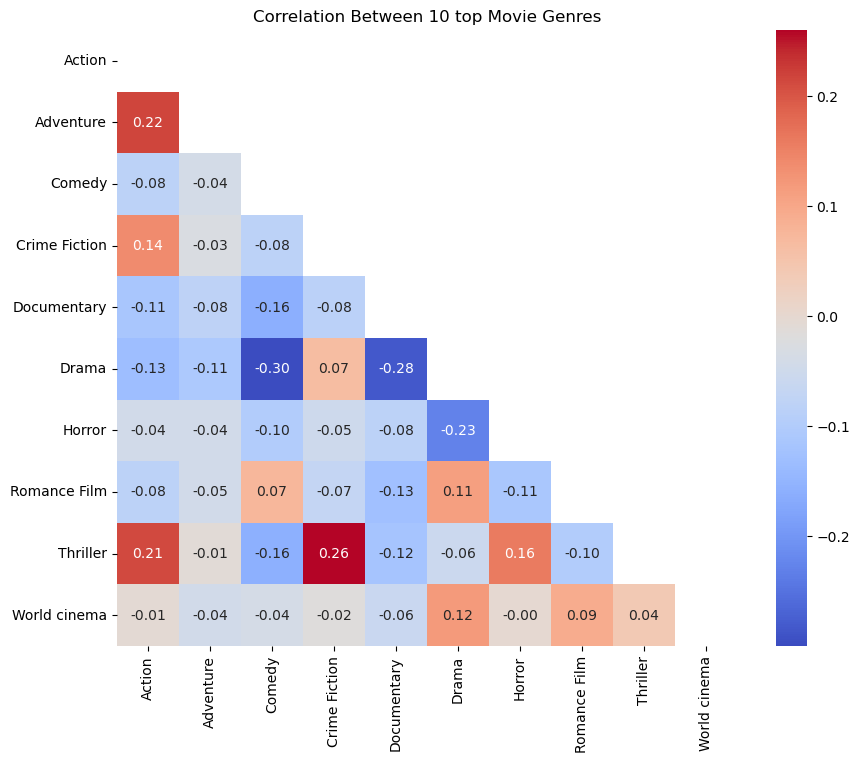

In [35]:
most_10commongenres,coverage10 = most_common_genres(preprocessed_movies, genre_counts_top_10, 10)
most_10commongenres = most_10commongenres.dropna(subset=['Genres'])

#Tranform the multi label genre of each movie into a binary matrix where each column represent a genre and each row a movie. If the movie is classified into the genre the value is 1 otherwise it is 0
mlb = MultiLabelBinarizer()

genre_binary_matrix = pd.DataFrame(mlb.fit_transform(most_10commongenres['Genres'].str.split(', ')), columns=mlb.classes_, index=most_10commongenres.index)
genre_correlation = genre_binary_matrix.corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))
sns.heatmap(genre_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between 10 top Movie Genres')


This heatmap illustrates how frequently two genres are used together to describe the same movie.\
For example, the combination of "Crime Fiction" and "Thriller" shows a moderate positive correlation (0.26), suggesting that these genres often co-occur, meaning that movies labeled as "Crime Fiction" frequently include elements of "Thriller" as well. However, this co-occurrence is only moderately consistent across the dataset.\
On the other hand, "Drama" and "Documentary" have a strong negative correlation (-0.28), indicating that these genres are rarely used together. This suggests that movies classified as "Drama" are typically not labeled as "Documentary" and vice versa.

Let's try this heat map for the top 30 genres now.

Index(['Action', 'Action/Adventure', 'Adventure', 'Animation',
       'Biographical film', 'Biography', 'Comedy', 'Comedy film',
       'Comedy-drama', 'Crime Fiction', 'Crime Thriller', 'Documentary',
       'Drama', 'Family Film', 'Fantasy', 'Horror', 'LGBT', 'Mystery',
       'Period piece', 'Psychological thriller', 'Romance Film',
       'Romantic comedy', 'Romantic drama', 'Science Fiction', 'Sports',
       'Thriller', 'War film', 'Western', 'World cinema'],
      dtype='object')


Text(0.5, 1.0, 'Correlation Between 10 top Movie Genres')

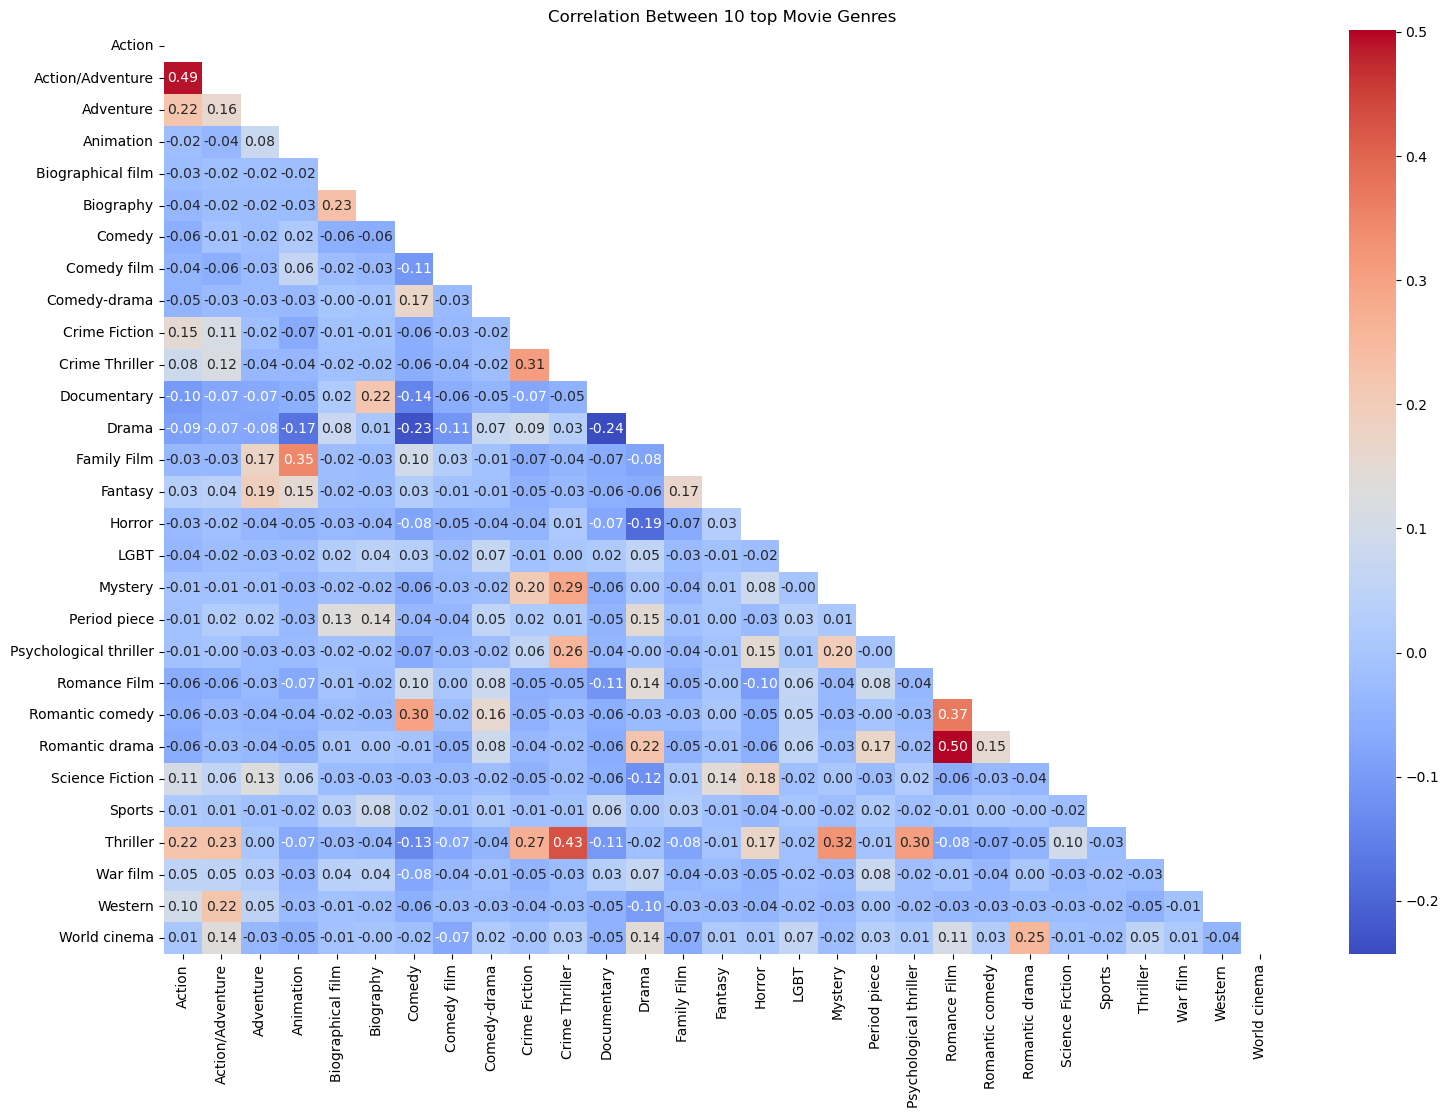

In [36]:
most_30commongenres,coverage30 = most_common_genres(preprocessed_movies, genre_counts_top_30, 30)
most_30commongenres = most_30commongenres.dropna(subset=['Genres'])

genre_binary_matrix = pd.DataFrame(mlb.fit_transform(most_30commongenres['Genres'].str.split(', ')), columns=mlb.classes_, index=most_30commongenres.index)
genre_correlation = genre_binary_matrix.corr()

print(genre_correlation.index)

plt.figure(figsize=(18, 12))
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))
sns.heatmap(genre_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between 10 top Movie Genres')

Here, we observe some logical correlations between genres. For example, "Romance Film" has a strong correlation (0.50) with "Romantic Drama," and "Thriller" is correlated with "Crime Thriller" (0.43). This reflects how closely related these genre classifications are.

Ideally, a "Crime Thriller" would always be classified as a "Thriller," so the correlation should be 1. However, since movies are sometimes labeled with just one of these terms, we see a lower correlation. This suggests potential inconsistencies in labeling, where similar genres are named differently or only partially.

One solution might be to group genres with similar names. However, it’s not always straightforward. For example, if we consider "Romantic Drama" and "Romantic Comedy," should both be grouped under "Romance"? Or should one go under "Drama" and the other under "Comedy"? Alternatively, should each be classified in both "Romance" and their respective sub-genres ("Drama" or "Comedy")? The choice of grouping depends on how we want to structure the genre hierarchy and whether we aim to capture both overarching themes and specific sub-genres.

## WAR MOVIES

In this section, we’ll conduct a brief analysis of movies classified as "War Movies." This is a straightforward, focused genre analysis over time, where we’ll examine trends in war movie production, particularly to see if there was an increase in production around major wartime periods, such as the World Wars.

In [37]:
War_movies = preprocessed_movies[preprocessed_movies['Genres'].str.contains(r'war', case=False, na=False)]
War_movies_comedy = War_movies[War_movies['Genres'].str.contains(r'comedy', case=False, na=False)]
War_movies_drama = War_movies[War_movies['Genres'].str.contains(r'drama', case=False, na=False)]
print(len(War_movies), len(War_movies_comedy), len(War_movies_drama))

2550 228 1697


Text(0.5, 1.0, 'Number of movies per year')

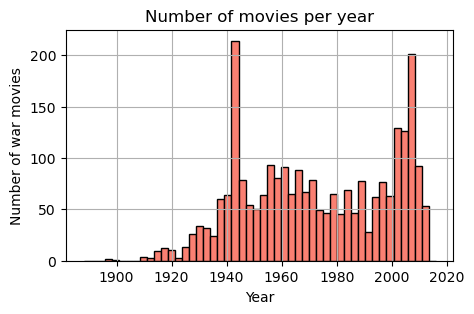

In [38]:
plt.figure(figsize=(5,3))
War_movies["Year"].hist(bins=50, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color = 'salmon', edgecolor = 'black')

plt.xlabel("Year")
plt.ylabel("Number of war movies")
plt.title("Number of movies per year")

The plot shows the number of war movies produced per year. There is a significant increase in war movie production during the 1940s, which aligns with World War II, suggesting that the conflict likely influenced the film industry. 
Another peak appears around the early 2000s.

We know that the repartition of the movie are right-screwed so let's look at the proportion instead of the number of movies.  

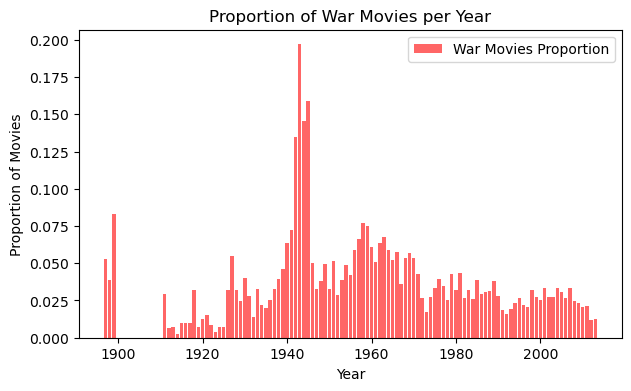

In [39]:
total_movies_per_year = preprocessed_movies.groupby('Year').size()
war_movies_per_year = War_movies.groupby('Year').size()

# Calculate the proportion of each category of movie per year
war_movies_proportion = war_movies_per_year / total_movies_per_year

plt.figure(figsize=(7, 4))
plt.bar(war_movies_proportion.index, war_movies_proportion.values, label='War Movies Proportion', color='red', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Proportion of Movies')
plt.title('Proportion of War Movies per Year')
plt.legend(loc='upper right')
plt.show()


Another interesting question to explore is whether these war films tend to lean more toward comedic or dramatic themes.

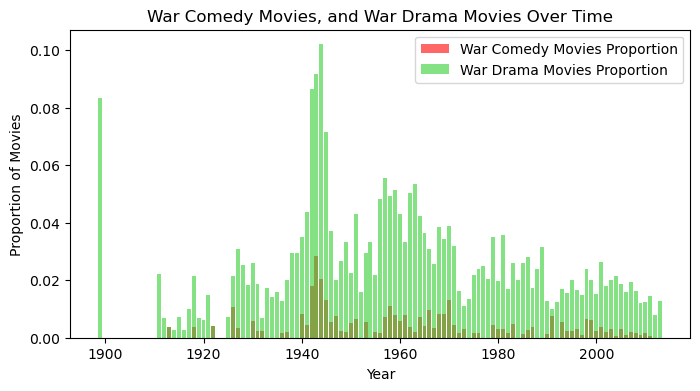

In [40]:
war_comedy_movies_per_year = War_movies_comedy.groupby('Year').size()
war_drama_movies_per_year = War_movies_drama.groupby('Year').size()

# Calculate the proportion of each category of movie per year
war_comedy_movies_proportion = war_comedy_movies_per_year / total_movies_per_year
war_drama_movies_proportion = war_drama_movies_per_year / total_movies_per_year

plt.figure(figsize=(8, 4))
plt.bar(war_comedy_movies_proportion.index, war_comedy_movies_proportion.values, label='War Comedy Movies Proportion', color='red', alpha=0.6)
plt.bar(war_drama_movies_proportion.index, war_drama_movies_proportion.values, label='War Drama Movies Proportion', color='limegreen', alpha=0.6)

plt.xlabel('Year')
plt.ylabel('Proportion of Movies')
plt.title('War Comedy Movies, and War Drama Movies Over Time')
plt.legend(loc='upper right')
plt.show()

The graph clearly shows that the theme of war is much more frequently portrayed from a dramatic rather than a comedic perspective.

## GENRES OVER TIME 

In this section, we will explore how the popularity of different genres varies over time. For now, we’ll focus on the ten most common genres.

In [41]:
# Select the top 10 genres
selected_genres = genre_counts_top_10['Genres'].values
genre_year_df = preprocessed_movies[['Year', 'Genres']].copy()

# Explode the genres into separate rows
genre_year_df = genre_year_df.assign(Movie_genres=genre_year_df['Genres'].str.split(', ')).explode('Genres')
genre_year_df = genre_year_df[genre_year_df['Genres'].isin(selected_genres)]

# Count the number of movies per genre per year
genre_year_counts = genre_year_df.groupby(['Year', 'Genres']).size().unstack(fill_value=0)

In [42]:
selected_genres

array(['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action',
       'World cinema', 'Crime Fiction', 'Documentary', 'Horror',
       'Adventure'], dtype=object)

In [43]:
genre_year_counts.columns   

Index(['Action', 'Adventure', 'Comedy', 'Crime Fiction', 'Documentary',
       'Drama', 'Horror', 'Romance Film', 'Thriller', 'World cinema'],
      dtype='object', name='Genres')

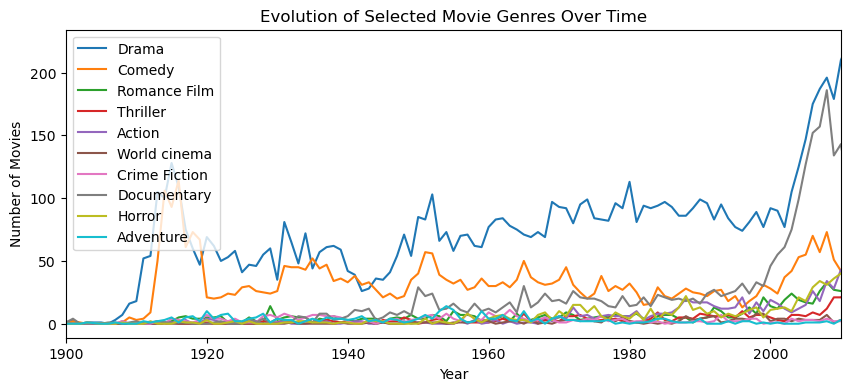

In [44]:
# Plot the evolution over time for each genre
plt.figure(figsize=(10, 4))
for genre in selected_genres:
    plt.plot(genre_year_counts.index, genre_year_counts[genre], label=genre)

# Set the range for the x-axis
plt.xlim(1900, 2010)

plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Evolution of Selected Movie Genres Over Time')
plt.legend()
plt.show()


The graph reveals significant variations in the popularity of movie genres over time. We will later examine whether these fluctuations correlate with historical events or crises.

# PARTIE 2

# Additional dataset : "World Important Events - Ancient to Modern"

Enfin, on veut clean notre dataset additionnel, création de catégories utiles pour l’analyse, comme « guerre », « crise économique », « période de stabilité ». On cherche encore ici à vectoriser et mettre sous forme de token certains types de mots en identifiant les catégories qui nous intéressent.
On veut éliminer les valeurs manquantes ainsi que les événements historiques beaucoup trop vieux pour notre analyse.
Peu importe la méthode utilisée pour tokeniser/vectroriser, expliquer ici pourquoi c'est approprié pour nos objectif et donner une  brève explication mathématique si possible.
On veut aussi transformer les formats de dates pour l’analyse temporelle à l'image de notre movie dataset.

## 1 - Data Collection

We start with an overview of the historical dataset, an open-source collection titled "World Important Events - Ancient to Modern World."  (Author: Saket Kumar)

In [45]:
raw_history_data= pd.read_csv("data/HistoricalDataset/historical.dataset.csv")
print(f"The initial dataframe has {len(raw_history_data)} lines.")

The initial dataframe has 1096 lines.


In [46]:
raw_history_data.head(3)

,Sl. No,Name of Incident,Date,Month,Year,Country,Type of Event,Place Name,Impact,Affected Population,Important Person/Group Responsible,Outcome
0,1,Indus Valley Civilization Flourishes,Unknown,Unknown,2600 BC,India,Civilization,Indus Valley,Development of one of the world's earliest urb...,Local inhabitants,Indus Valley people,Positive
1,2,Battle of the Ten Kings,Unknown,Unknown,1400 BC,India,Battle,Punjab,Rigvedic tribes consolidated their control ove...,Rigvedic tribes,Sudas,Positive
2,6,Establishment of the Delhi Sultanate,Unknown,Unknown,1206,India,Political,Delhi,Muslim rule established in parts of India,People of Delhi and surrounding regions,QutbUnknownudUnknowndin Aibak,Mixed


## Data Cleaning

We can remove the columns "Place Name","Date" and "Month" of the dataset. We don't need such precision in the historical events date because our analysis will focus on their impact on film industry, and films are usually released years after. The Place Name is also a precision that we won't need, as we are working at the scale of countries.

In [67]:
# drop columns that we don't need.
cleaned_data_history = raw_history_data.copy()
cleaned_data_history.drop(columns=["Place Name","Date", "Month","Sl. No"], inplace=True)

In [69]:
# we can see that some of the dates are before Christ (BC). We can safely remove them, knowing that movies didn't exist at that time.
cleaned_data_history = cleaned_data_history[~cleaned_data_history['Year'].str.contains('BC')]

The historical dataset starts from very ancient times, we want to only keep events happening after the first movie was released. 

We also don't want the historical event that happens after the last movie that we got.

In [71]:
# for this purpose, we need to make the date values more convenient to work with, by converting the column ['Year'] from str to int
cleaned_data_history.loc[:, 'Year'] = cleaned_data_history.loc[:, 'Year'].astype(int)
    
# get the year of the first released movie
first_movie_year = preprocessed_movies['Year'].min()
last_movie_year = preprocessed_movies['Year'].max()
print('In our dataset, the first movie that was released was in', int(first_movie_year))
print('The last movie that was released was in', int(last_movie_year))
    
# remove historical events that happened before the first movie was released
cleaned_data_history = cleaned_data_history[cleaned_data_history['Year'] >= first_movie_year]
cleaned_data_history = cleaned_data_history[cleaned_data_history['Year'] <= last_movie_year]
first_event_year = cleaned_data_history['Year'].min()
last_event_year = cleaned_data_history['Year'].max()

print('\n The first event in the historical dataset that happened after the first movie happened in', int(first_event_year))
print('The last event in the historical dataset that happened before the last movie happened in', int(last_event_year))

In our dataset, the first movie that was released was in 1888
The last movie that was released was in 2016

 The first event in the historical dataset that happened after the first movie happened in 1888
The last event in the historical dataset that happened before the last movie happened in 2016


To show on a world map the number of events happening in each country we will use a geopandas dataset. Some countries of the historical dataset have different names than geopandas, so we will need to format them to match. First of all, a primary analysis of these dfferences:

In [74]:
# we can remove what is between parenthesis and remove outliers, for example, "Spain/USA". 

shapefile_path = 'data/geopandas/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)
geopandas_countries = world['NAME'].unique()
events_countries = cleaned_data_history['Country'].unique()

# Elements in events_countries but not in geopandas_countries
differences = [item for item in events_countries if item not in geopandas_countries]
print(f"These countries from events_countries are not taken into account in geopandas map \n{differences}")

These countries from events_countries are not taken into account in geopandas map 
['UK', 'USSR', 'Korea', 'Singapore', 'Almaty', 'Bukhara', 'Malaya', 'Tehran', 'Samarkand', 'Maldives', 'Basra', 'Punakha', 'Soviet Union', 'Uzbek SSR', 'Addu Atoll', 'Kuwait, Iraq', 'Mosul', 'Zhanaozen', 'USA', 'Spain/USA', 'Congo (DRC)', 'Equatorial Guinea', 'Seychelles', 'Cape Verde', 'GuineaUnknownBissau', 'Comoros', 'Central African Republic', 'Congo (Brazzaville)', "Ivory Coast (Côte d'Ivoire)", 'Swaziland (Eswatini)', 'South Sudan']


Here are the steps to make these countries match:

In [75]:
#Replace USSR and Soviet Union by Russia as we are interested in the geographical location of the events
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'USSR', 'Russia')
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'Soviet Union', 'Russia')

#replace name of countries to the appropriate format
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'USA', 'United States of America')
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'UK', 'United Kingdom')
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'Zhanaozen', 'Kazakhstan')

#Actually ! 'Tehran' is the capital of Iran
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'Tehran', 'Iran')

# remove all the remaining rows of the dataset that contain a country that is not in the geopandas map
cleaned_data_history = cleaned_data_history[cleaned_data_history['Country'].isin(geopandas_countries)]

len(cleaned_data_history)

660

The dataset is reduced to 660, but that's fine because we don't need a very large dataset for the historical events. Instead we want to choose relevant ones to analyse their impact on film industry.

### > Missing values

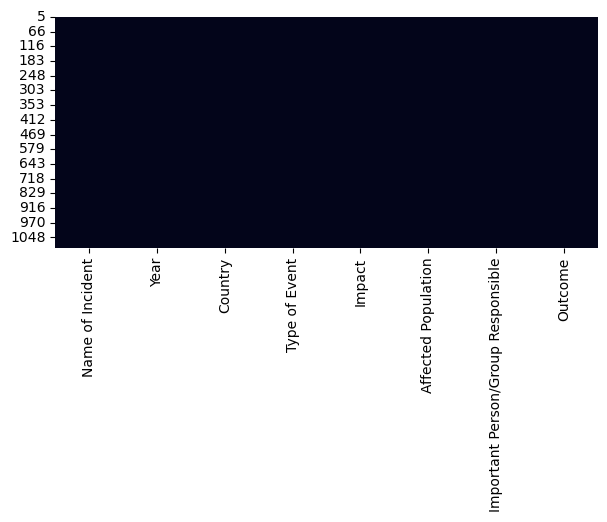

In [77]:
cleaned_data_history.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#Plot for the missing values
plt.figure(figsize=(7, 3))
sns.heatmap(cleaned_data_history.isnull(), cbar=False)
plt.show()

In [80]:
cleaned_data_history.info()

<class 'pandas.core.frame.DataFrame'>
Index: 660 entries, 5 to 1095
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Name of Incident                    660 non-null    object
 1   Year                                660 non-null    int64 
 2   Country                             660 non-null    object
 3   Type of Event                       660 non-null    object
 4   Impact                              660 non-null    object
 5   Affected Population                 660 non-null    object
 6   Important Person/Group Responsible  660 non-null    object
 7   Outcome                             660 non-null    object
dtypes: int64(1), object(7)
memory usage: 46.4+ KB


There are no missing values in the cleaned data history. 

In [87]:
# save the cleaned data to a csv file
processed_data_path = 'data/Preprocessed_data/preprocessed_history.csv'
cleaned_data_history.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)

In [88]:
preprocessed_history = pd.read_csv("data/Preprocessed_data/preprocessed_history.csv")
preprocessed_history.head(2)

,Name of Incident,Year,Country,Type of Event,Impact,Affected Population,Important Person/Group Responsible,Outcome
0,Partition of India,1947,India,Partition,Creation of India and Pakistan; massive popula...,"Hindus, Muslims, Sikhs","British Empire, Indian political leaders",Negative
1,IndoUnknownPakistani War of 1971,1971,India,War,Led to the independence of Bangladesh,Bengalis in East Pakistan,"Indian Military, Mukti Bahini",Negative



At the end, a new csv file containing the cleaned data was created, in the file preprocessed_history.csv

## 3 - Exploratory analysis

Let's visualize the  distribution of the number of events that happened each year in the historical dataset.

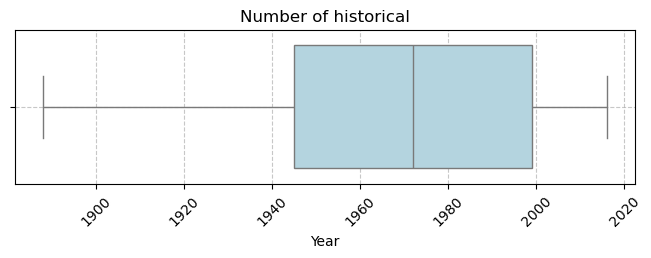

In [89]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=preprocessed_history['Year'].astype(int), color='lightblue')
plt.title('Number of historical')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


We chose to remove columns with mixed outcome because these corresponding events would be too complex for analyzing their direct impact on film industry.

In [90]:
#Drop rows with "Mixed" in the outcome column
preprocessed_history = cleaned_data_history[cleaned_data_history["Outcome"] != "Mixed"]

Text(0.5, 1.0, 'Historical events  each year')

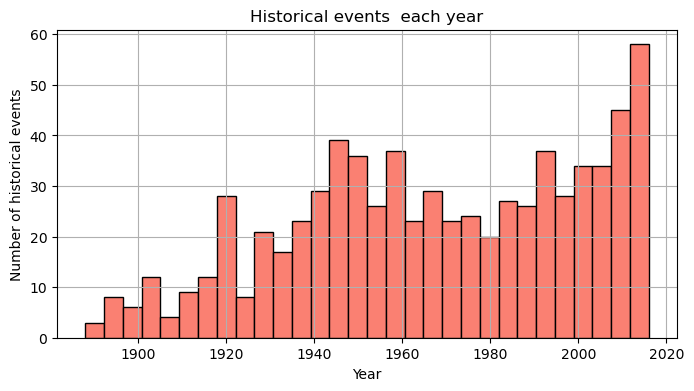

In [ ]:
plt.figure(figsize=(8, 4))

preprocessed_history["Year"].hist(bins=30, range=(preprocessed_history["Year"].min(), preprocessed_history["Year"].max()), color = 'salmon', edgecolor = 'black') 
plt.xlabel("Year")
plt.ylabel("Number of historical events")
plt.title("Historical events  each year")  

In [ ]:
top5 = preprocessed_history["Country"].value_counts().iloc[:5]
top5_countries = preprocessed_history[preprocessed_history["Country"].isin(top5.index[:5])]

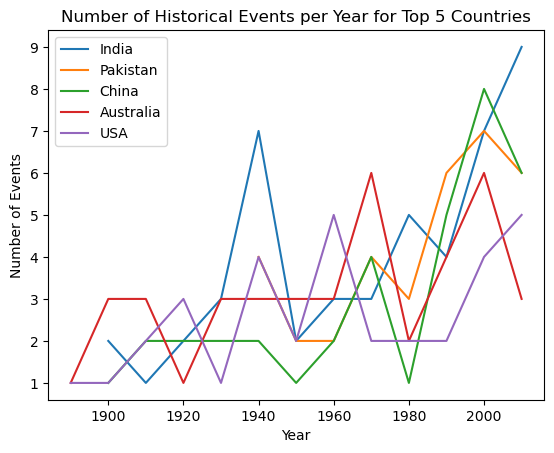

In [ ]:
for country in top5_countries["Country"].unique():
    country_data = top5_countries[top5_countries["Country"] == country].copy()
    country_data['Decade'] = (country_data['Year'] // 10) * 10
    yearly_counts = country_data.groupby('Decade').size()
    plt.plot(yearly_counts.index, yearly_counts.values, '-', label=country)

plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.title('Number of Historical Events per Year for Top 5 Countries')
plt.legend()
plt.show()

#PIRE GRAPH DU MONDE je vais essayer d ameliorer ca au plus vite

# Historical Data Analysis


## (pour moi on est encore dans la party exploration en dessous)

## Types of events

In [ ]:
#histogram of types of events
#Number of event types in the dataset
t_events = preprocessed_history['Type of Event'].str.split(', ').explode().unique()
print(len(t_events),t_events)

278 ['Partition' 'War' 'Nuclear Test' 'Terrorism' 'National Movement'
 'Agricultural Revolution' 'Military Operation' 'Military Conflict'
 'Legislation' 'Criminal Incident' 'Political' 'Industrial Disaster'
 'Economic Policy' 'Infrastructure' 'Sports' 'Natural Disaster'
 'Space Exploration' 'Financial Technology' 'Telecommunications'
 'Environmental/Social' 'International Cooperation' 'Military'
 'Administrative' 'Massacre' 'Civil Disobedience Movement'
 'Violent Protest' 'Civil Disobedience' 'Conference'
 'Political Declaration' 'Mass Protest' 'Negotiation' 'Famine'
 'Political Decision' 'Political Integration' 'Constitutional Adoption'
 'Central Banking Institution' 'Space Agency' 'Political Party'
 'Regulatory Body' 'Country Formation' 'International Relations'
 'Constitutional' 'Political Movement' 'Economic/Infrastructure'
 'Monument' 'International Agreement' 'Scientific Organization'
 'International Recognition' 'Social Welfare Program'
 'Constitutional Amendment' 'Government Ag

There are 310 different event types in the historcical data. Just as we did for the genres in the movies, we can attempt to select a more relevant subset of these types. For this preliminary analysis, we can select a subset of these events (Wars for example? - maybe regroup war dates, see if there is a period with many wars which correlates with movies about war?)

Let's count the number of dates in each event type.

In [ ]:
e_types_counts = preprocessed_history['Type of Event'].str.split(', ').explode().value_counts()
e_types_counts

Type of Event
Political                    63
Independence                 45
Military Conflict            28
Military                     24
Economic Policy              18
                             ..
Election                      1
Policy/Legislation            1
Environmental Legislation     1
Judicial/Political            1
Religious                     1
Name: count, Length: 278, dtype: int64

Looking at the distribution of types of events:

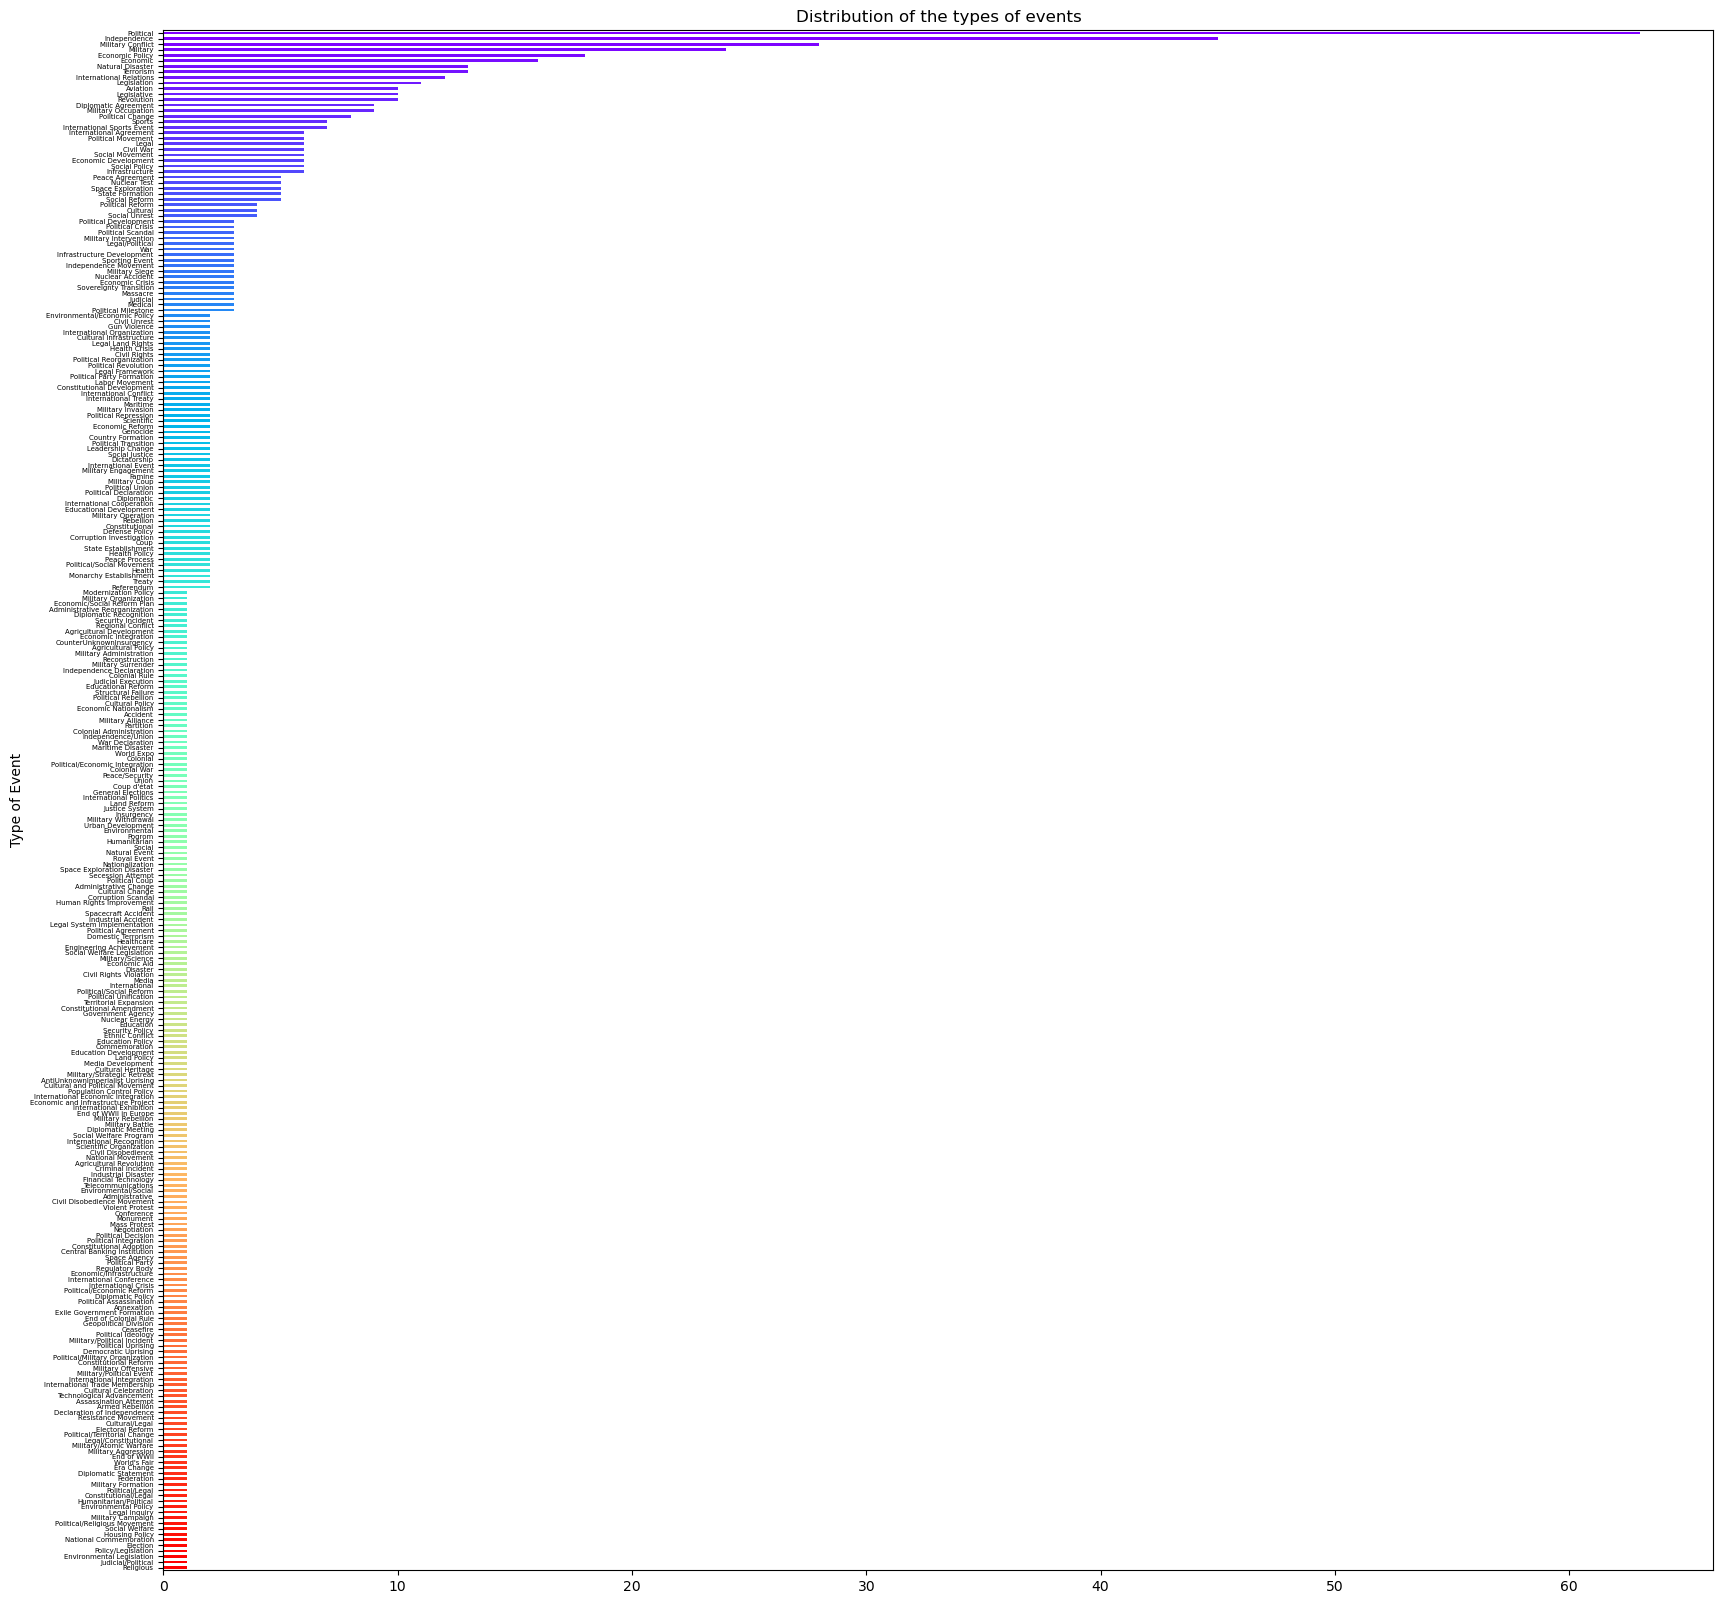

In [ ]:
#Event type distribution

# For the bar colors
num_bars = len(e_types_counts)
colors = plt.cm.rainbow(np.linspace(0, 1, num_bars))

# Plot with rainbow colors assigned to each bar
plt.figure(figsize=(20, 20))
e_types_counts.plot(kind='barh', color=colors)
plt.title('Distribution of the types of events')
plt.yticks(fontsize=5) 
plt.gca().invert_yaxis() 



By quick visual analysis, we see that a large number of our types of events only have one occurence.

In [ ]:
t_events = e_types_counts[e_types_counts <= 1]
rare_t_events = len(t_events)

print(f"Number of event types assigned to 10 dates or less  : {rare_t_events}")

Number of event types assigned to 10 dates or less  : 177


One way to select a subset of dates: by their number of assigned dates. This is however debatably relevant because some types of events could be rare but give a much better descriptive indication of the nature of the event. For example, the top represented types of events are "Political" and "Independence" which are guite vague in nature. Moreover, we see that "Military" and "Military Conflict" have a close number of occurences. This could mean that they have a strong association: we could therefore try to aggregate the event types that are always associated together. 

Lets analyse the correlation between types of events:

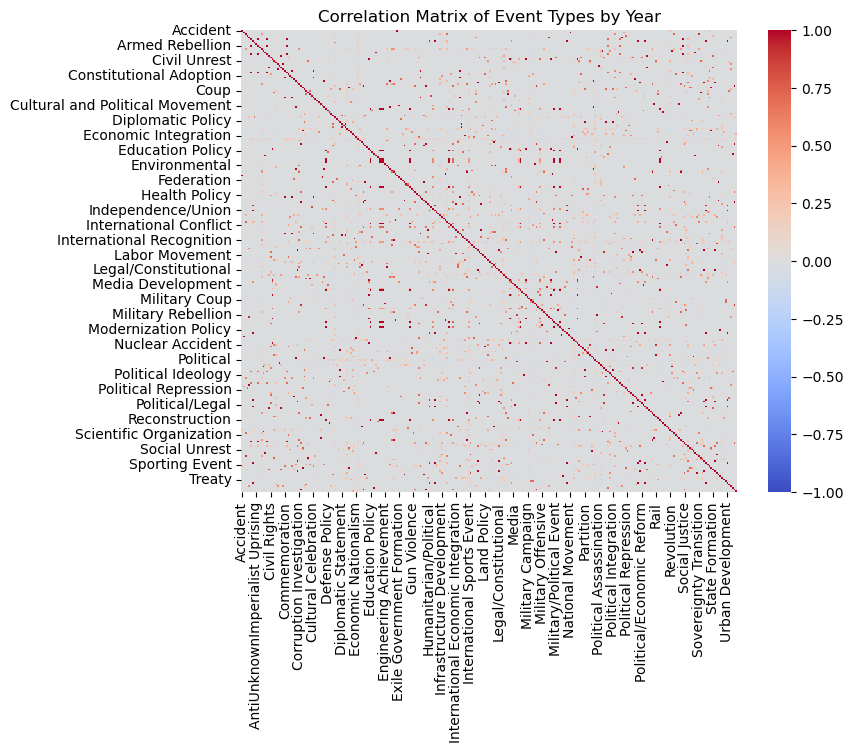

In [ ]:
event_type_binary = pd.get_dummies(preprocessed_history['Type of Event'])
df_encoded = pd.concat([preprocessed_history[['Year']], event_type_binary], axis=1)
df_encoded
event_counts_by_year = df_encoded.groupby('Year').sum()
correlation_matrix = event_counts_by_year.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Event Types by Year')
plt.show()

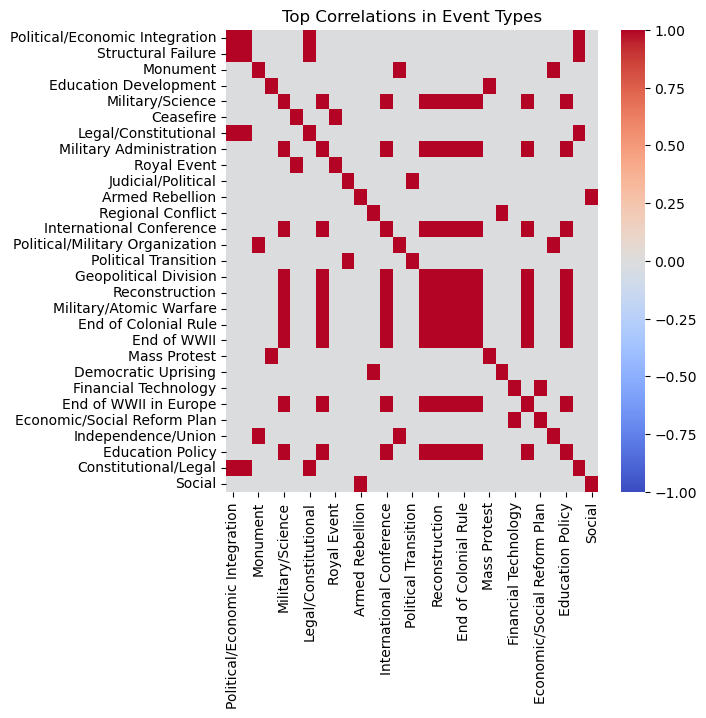

In [ ]:
corr_values = correlation_matrix.unstack().reset_index()
corr_values.columns = ['Event Type 1', 'Event Type 2', 'Correlation']

# Remove self-correlations (i.e., pairs where Event Type 1 == Event Type 2)
corr_values = corr_values[corr_values['Event Type 1'] != corr_values['Event Type 2']]

# Step 2: Sort the pairs by absolute correlation value
corr_values = corr_values.reindex(corr_values['Correlation'].abs().sort_values(ascending=False).index)

# Step 3: Select the top N highest correlations (e.g., top 5)
top_n = 20
top_corrs = corr_values.head(top_n)

# Step 4: Create a subset matrix with only the top N correlations
top_event_types = list(set(top_corrs['Event Type 1']).union(set(top_corrs['Event Type 2'])))
subset_matrix = correlation_matrix.loc[top_event_types, top_event_types]

# Display the subset matrix
#print("Subset of the correlation matrix (top correlations):")
#print(subset_matrix)

# Visualize the subset matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(subset_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Top Correlations in Event Types')
plt.show()

In [ ]:
corr_values

,Event Type 1,Event Type 2,Correlation
65146,Reconstruction,Geopolitical Division,1.000000
67010,Royal Event,Ceasefire,1.000000
41771,Mass Protest,Education Development,1.000000
73893,Structural Failure,Political/Economic Integration,1.000000
20172,Education Policy,Military Administration,1.000000
...,...,...,...
26052,Genocide,Political,-0.001806
18198,Economic Policy,International Sports Event,-0.001649
35649,International Sports Event,Economic Policy,-0.001649
43281,Military,Nuclear Test,0.001390


In [ ]:

# Remove self-correlations (i.e., pairs where Event Type 1 == Event Type 2)
corr_values = corr_values[corr_values['Event Type 1'] != corr_values['Event Type 2']]

# Step 2: Get the occurrences of event types (frequencies) from e_types_counts
event_occurrences = e_types_counts

# Step 3: Aggregate event types with a correlation of 1
# Filter corr_values to get only the pairs with correlation 1
highly_correlated = corr_values[corr_values['Correlation'] == 1]

# Perform aggregation: Replace the event type with frequency 1
aggregated_corr_values = []
maintained_event_types = []  # List to keep track of the event types that are maintained

for _, row in highly_correlated.iterrows():
    event1, event2 = row['Event Type 1'], row['Event Type 2']
    
    # Check the frequencies of both event types
    freq_event1 = event_occurrences.get(event1, np.nan)
    freq_event2 = event_occurrences.get(event2, np.nan)
    
    # Replace the event with frequency 1
    if freq_event1 == 1 and freq_event2 != 1:
        # Replace event1 with event2
        aggregated_corr_values.append({
            'Event Type 1': event2, 
            'Event Type 2': event2, 
            'Correlation': 1
        })
        # Track which event type is maintained (event2 is maintained)
        maintained_event_types.append(event2)
    elif freq_event2 == 1 and freq_event1 != 1:
        # Replace event2 with event1
        aggregated_corr_values.append({
            'Event Type 1': event1, 
            'Event Type 2': event1, 
            'Correlation': 1
        })
        # Track which event type is maintained (event1 is maintained)
        maintained_event_types.append(event1)
    else:
        # If neither has frequency 1, keep the original pair
        aggregated_corr_values.append({
            'Event Type 1': event1, 
            'Event Type 2': event2, 
            'Correlation': row['Correlation']
        })
        # Track both event types as maintained
        maintained_event_types.append(event1)
        maintained_event_types.append(event2)

# Convert the aggregated list back into a DataFrame
aggregated_corr_values_df = pd.DataFrame(aggregated_corr_values)

# Display the aggregated correlations
print("\nAggregated Correlations:")
print(aggregated_corr_values_df)

# Display the maintained event types
print("\nMaintained Event Types:")
print(set(maintained_event_types))  # Using set to avoid duplicates


Aggregated Correlations:
                  Event Type 1                    Event Type 2  Correlation
0               Reconstruction           Geopolitical Division          1.0
1                  Royal Event                       Ceasefire          1.0
2                 Mass Protest           Education Development          1.0
3           Structural Failure  Political/Economic Integration          1.0
4             Education Policy         Military Administration          1.0
..                         ...                             ...          ...
427  International Recognition            Environmental/Social          1.0
428      Geopolitical Division     Declaration of Independence          1.0
429  International Integration            Diplomatic Statement          1.0
430      Geopolitical Division            End of Colonial Rule          1.0
431         Independence/Union              Political Uprising          1.0

[432 rows x 3 columns]

Maintained Event Types:
{'Structural 

Bon tout compte fait c'est pas hyper pertinent ce que j'ai fait la donc a voir si on garde mais je pense laisser tomber. En gros j'essayer de voir si je pouvais grouper les types d'events sous le plus grand mais ca a l'air un peu bourbier.

For the time being, in order to study a manageble subset of the data, we can concentrate on a arbitrary type of event. War for example.

### Geographical distribution of events

In [ ]:
country_counts = preprocessed_history['Country'].value_counts()
country_counts

Country
India        48
Australia    41
Pakistan     34
China        34
USA          34
             ..
Cameroon      1
Eritrea       1
Sudan         1
Benin         1
Mexico        1
Name: count, Length: 104, dtype: int64

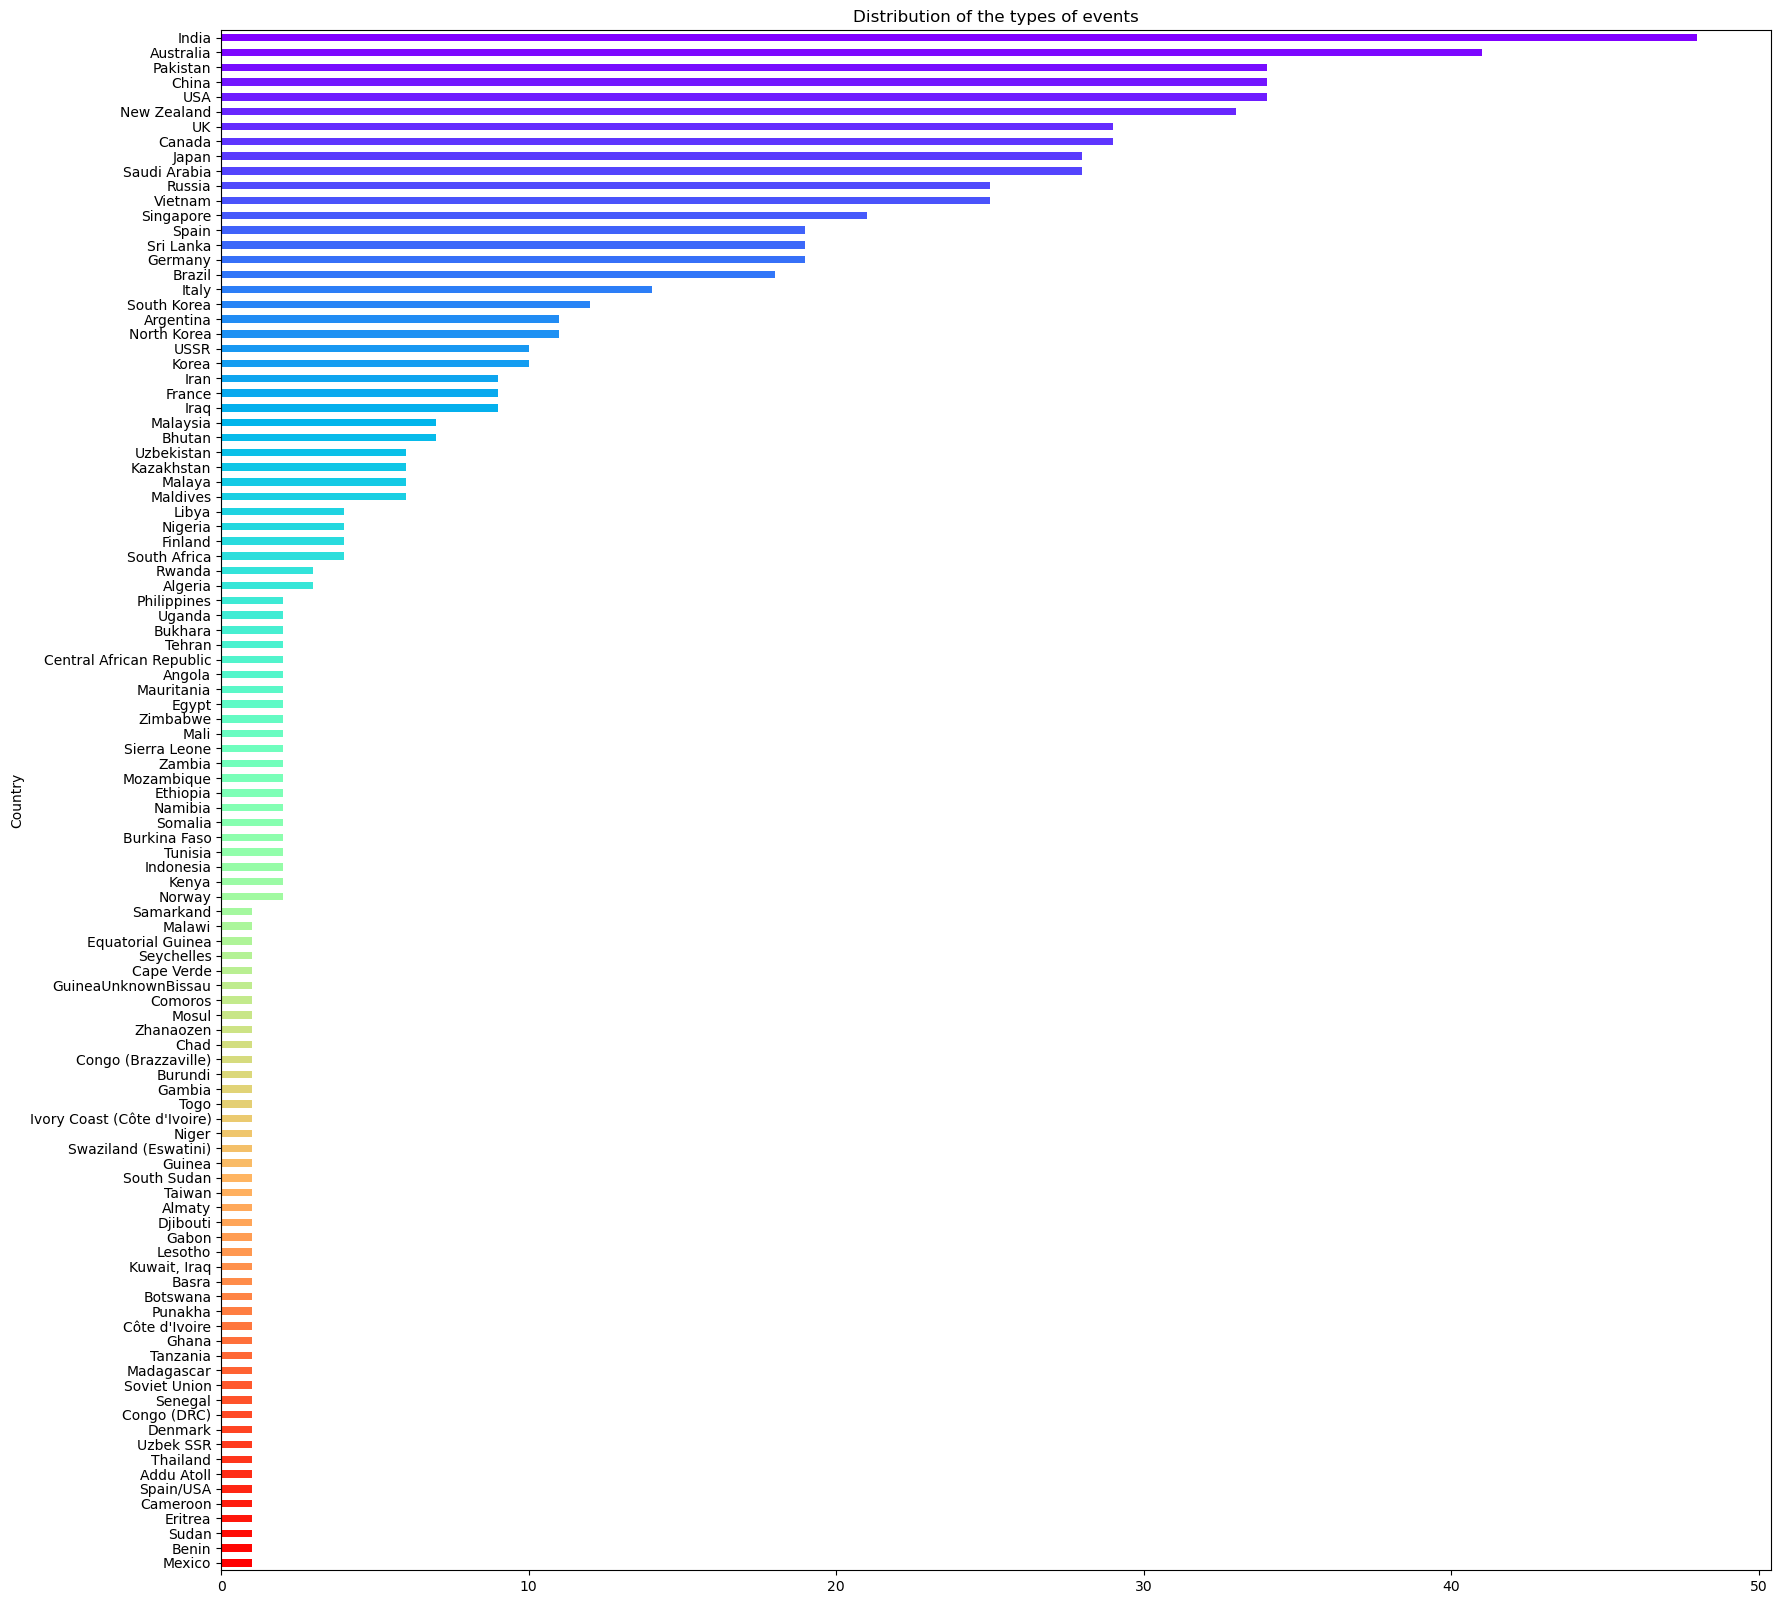

In [ ]:
#Country event distribution
# For the bar colors
num_bars = len(country_counts)
colors = plt.cm.rainbow(np.linspace(0, 1, num_bars))

# Plot with rainbow colors assigned to each bar
plt.figure(figsize=(20, 20))
country_counts.plot(kind='barh', color=colors)
plt.title('Distribution of the types of events')
plt.yticks(fontsize=10) 
plt.gca().invert_yaxis() 

In [ ]:
country_list = preprocessed_history['Country'].unique()
country_list

array(['India', 'UK', 'Pakistan', 'Sri Lanka', 'China', 'Russia', 'USSR',
       'Japan', 'Australia', 'New Zealand', 'Korea', 'South Korea',
       'North Korea', 'Vietnam', 'Saudi Arabia', 'Singapore', 'Iran',
       'Iraq', 'Almaty', 'Bukhara', 'Bhutan', 'Malaya', 'Tehran',
       'Kazakhstan', 'Samarkand', 'Malaysia', 'Uzbekistan', 'Maldives',
       'Basra', 'Punakha', 'Soviet Union', 'Uzbek SSR', 'Addu Atoll',
       'Kuwait, Iraq', 'Mosul', 'Zhanaozen', 'Taiwan', 'Indonesia',
       'Philippines', 'Thailand', 'USA', 'Canada', 'France', 'Italy',
       'Spain', 'Spain/USA', 'South Africa', 'Finland', 'Denmark',
       'Norway', 'Nigeria', 'Kenya', 'Algeria', 'Libya', 'Tunisia',
       'Rwanda', 'Uganda', 'Somalia', 'Botswana', 'Namibia',
       "Côte d'Ivoire", 'Ghana', 'Tanzania', 'Madagascar', 'Ethiopia',
       'Mozambique', 'Zambia', 'Senegal', 'Congo (DRC)', 'Sierra Leone',
       'Mali', 'Burkina Faso', 'Zimbabwe', 'Egypt', 'Cameroon', 'Eritrea',
       'Sudan', 'Benin', 'M

There is some cleaning to be done on the names of the countries: for example, USSR must be merged to Russia, we can remove what is between parenthesis and remove outliers, for example, "Spain/USA". 

In [ ]:
world = gpd.read_file(shapefile_path)
country_list2 = world['NAME'].unique()
country_list2

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

Exmple de fonction pour le mapping: besoin d'être rectifié: je sais pas comment faire un path general pour tout le monde, j'ai exporté tout ce qu'il faut normalement mais il faut >pip install geopandas 

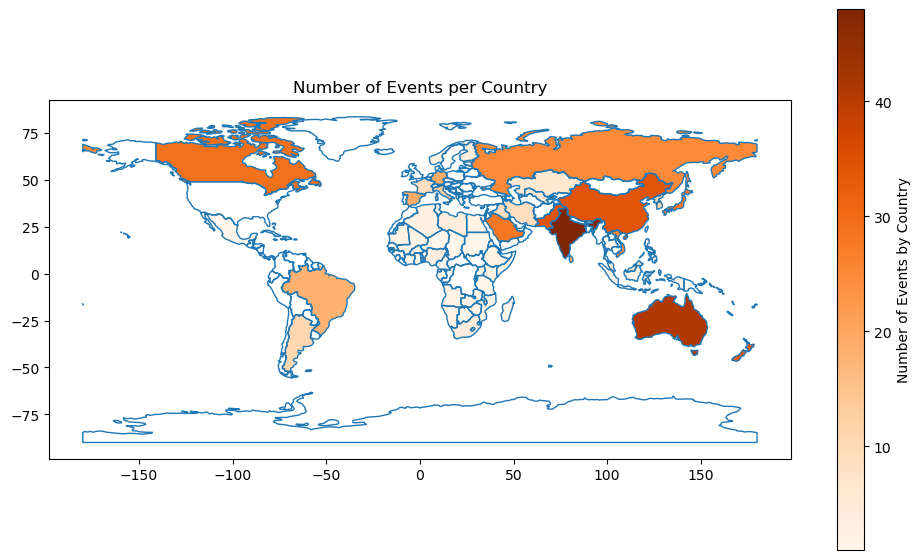

In [ ]:

# Step 1: Aggregate the number of events per country
event_counts = preprocessed_history['Country'].value_counts()
event_counts = event_counts.reset_index()  # Convert to DataFrame for easier merging
event_counts.columns = ['Country', 'Event_Count']  # Rename columns for clarity

# Step 2: Load the world map from the downloaded shapefile
shapefile_path = 'data/geopandas/ne_110m_admin_0_countries.shp'

# Load the shapefile into a GeoDataFrame
world = gpd.read_file(shapefile_path)

# Step 3: Ensure column name in world GeoDataFrame is 'Country'
world = world.rename(columns={'NAME': 'Country'})  # Adjust if necessary depending on the shapefile

# Step 4: Merge the event counts with the world map
# Perform the merge by using 'Country' as the key for both DataFrames
merged = world.merge(event_counts, on='Country', how='left')

# Step 5: Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.tight_layout()

# Plot country boundaries
world.boundary.plot(ax=ax, linewidth=1)

# Plot the event counts on the map, using the 'Oranges' color map
# Use 'Event_Count' as the color column for the merged DataFrame
merged.plot(column='Event_Count', ax=ax, legend=True,
            legend_kwds={'label': "Number of Events by Country",
                         'orientation': "vertical"},
            cmap='Oranges')

# Add a title to the plot
plt.title("Number of Events per Country")

# Show the plot
plt.show()

# Case Study: India

In [ ]:
India_events = preprocessed_history[preprocessed_history['Country']=='India']
India_movies = preprocessed_movies[preprocessed_movies['Countries']=='India']

In [ ]:
India_events.head()

,Sl. No,Name of Incident,Year,Country,Type of Event,Impact,Affected Population,Important Person/Group Responsible,Outcome
0,9,Partition of India,1947,India,Partition,Creation of India and Pakistan; massive popula...,"Hindus, Muslims, Sikhs","British Empire, Indian political leaders",Negative
1,10,IndoUnknownPakistani War of 1971,1971,India,War,Led to the independence of Bangladesh,Bengalis in East Pakistan,"Indian Military, Mukti Bahini",Negative
2,11,PokhranUnknownII Nuclear Tests,1998,India,Nuclear Test,India declared itself a nuclear state,International community,Atal Bihari Vajpayee,Mixed
3,12,Mumbai Terror Attacks,2008,India,Terrorism,Highlighted the threat of international terrorism,Citizens of Mumbai,LashkarUnknowneUnknownTaiba,Negative
4,16,Swadeshi Movement,1905,India,National Movement,Promoted Indian goods; protest against British...,Indian nationalists,Indian National Congress,Positive


In [ ]:
India_events["Type of Event"].value_counts()

Type of Event
Terrorism                      3
Political                      3
Nuclear Test                   2
Military Conflict              2
Legislation                    2
Economic Policy                2
Space Exploration              2
Sports                         2
Partition                      1
Famine                         1
Violent Protest                1
Civil Disobedience             1
Political Declaration          1
Mass Protest                   1
Negotiation                    1
Political Integration          1
Political Decision             1
Massacre                       1
Constitutional Adoption        1
Central Banking Institution    1
Space Agency                   1
Political Party                1
Civil Disobedience Movement    1
Environmental/Social           1
Administrative                 1
Military                       1
International Cooperation      1
War                            1
Telecommunications             1
Financial Technology         

## COMMENT dans le dataset on comprend si un evenement a été vraiment important ou non??

La prochaine étape est de faire des plots, voici mes idées mais rajoutez en à votre guise!! 

- Proportion de chaque genre dans les films sortis chaque année. (lineplot?)  (update Fait dan genre analysis)
- Heatmap temporelle avec les années et les genres pourrait aussi aider à voir les pics et baisses de popularité des genres.
- Comparer les genres populaires à des périodes historiques précises (avant, pendant, après).
- Ligne temporelle des revenus du box office pour des genres particuliers, avec des annotations pour les films les plus réussis. Les pics ou succès importants peuvent être marqués pour voir si d'autres films de genre similaire ont suivi. (matplotib.pyplot)
- Montrez la durée pendant laquelle un genre reste populaire après le succès d’un film spécifique. Chaque barre représente un genre et montre la période pendant laquelle il est resté en tendance. (barplot?)
- Carte géographique et graphique pour montrer l’origine des films (par pays) et un graphique en barres empilées pour voir comment les genres évoluent dans les différentes régions, en mettant en avant la diffusion de genres américains. (plotly.express.choropleth et seaborn)


Autres idées de chose à regarder par rapport au nouveau dataset: 
- si le nombre de negative outcome historique ont une correlation avec le nombre de comedies or tragedies dans les genre types?